In [1]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
year = 20
donors_csv = f"./output/donors_recip_agg_pred_lastname_trunc.csv"

In [3]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,recip_id,name_new,realcode,gender,occupation,city,state,total_donated,donation_count,...,seat,ran_general,type,cmte_id,pac_short,recip_id_pac,cand_id,recip_is_pac,dem_ratio,level
0,1,C60000015,republican national committee republican natio...,B1500,,NaN,WASHINGTON,DC,77820848.0,4793,...,NaN,NaN,NaN,C60000015,RNC/Repub National State Elections Cmte,C60000015,NaN,True,NaN,PAC
1,,N00000802,,Z9000,,NaN,NaN,,72634500.0,75,...,PRES,,O,NaN,NaN,NaN,NaN,False,-0.420059,President
2,1,C60000262,dnc general fund dnc general fund,K1000,,NaN,WASHINGTON,DC,40192970.0,2247,...,NaN,NaN,NaN,C60000262,DNC/Non-Federal Corporate,C60000262,NaN,True,NaN,PAC
3,1,C60000205,at&t at&t,B1500,,NaN,WASHINGTON,DC,32889365.0,9112,...,NaN,NaN,NaN,C60000205,NRCC/Non-Federal,C60000205,NaN,True,NaN,PAC
4,1,C60000148,at&t at&t,H4300,,NaN,WASHINGTON,DC,30116512.0,2572,...,NaN,NaN,NaN,C60000148,NRSC/Non-Federal,C60000148,NaN,True,NaN,PAC
5,1,C60000080,dccc nonfederal receipts-c dccc nonfederal rec...,Z9100,,NaN,WASHINGTON,DC,22149421.0,545,...,NaN,NaN,NaN,C60000080,DCCC/Non-Federal Account 1,C60000080,NaN,True,NaN,PAC
6,1,C60000619,bacardi-martini usa inc bacardi-martini usa inc,K1000,,NaN,WASHINGTON,DC,20752086.0,963,...,NaN,NaN,NaN,C60000619,DSCC/Non-Federal Corporate,C60000619,NaN,True,NaN,PAC
7,1,C60001450,mci worldcom mci worldcom,K1000,,NaN,WASHINGTON,DC,16237657.0,1559,...,NaN,NaN,NaN,C60001450,DCCC/Non-Federal Account 1,C60001450,NaN,True,NaN,PAC
8,1,C60000247,i b e w educational committee i b e w educatio...,LB100,,NaN,WASHINGTON,DC,13487450.0,217,...,NaN,NaN,NaN,C60000247,DNC/Non-Federal General,C60000247,NaN,True,NaN,PAC
9,1,C60000288,dccc nonfederal receipts-i dccc nonfederal rec...,Z9100,,NaN,WASHINGTON,DC,9651243.0,48,...,NaN,NaN,NaN,C60000288,DCCC/Non-Federal Account 5,C60000288,NaN,True,NaN,PAC


In [4]:
donors["level"].value_counts()

level
PAC          14768809
House        13329955
President     4432438
Unknown         18200
Name: count, dtype: int64

In [5]:
donors["party"].value_counts()

party
D    10233961
R     8405383
I      310080
3       39094
L       17500
U         137
Name: count, dtype: int64

In [6]:
donors[["recip_id", "name_y"]].value_counts()

recip_id   name_y                               
C00003418  Republican National Cmte                 1593676
C00694323  WinRed                                    994887
N00001669  Joe Biden (D)                             863872
N00023864  Donald Trump (R)                          819862
C00010603  DNC Services Corp                         809651
                                                     ...   
C00714139  Dump the Chump                                 1
C00714113  Big Tree PAC                                   1
C00714097  Blake Harrison Victory Fund                    1
C00713834  Outraise PAC                                   1
C00782490  Americans for Conservative Government          1
Name: count, Length: 34047, dtype: int64

In [7]:
donors["seat"].value_counts()

seat
PRES    4432438
VTS1     493932
GAS2     401963
TXS2     256932
MAS1     241500
         ...   
CA00          5
TX00          5
SC00          3
ASAS          2
              1
Name: count, Length: 578, dtype: int64

In [8]:
donors[donors["indian"] == True]["seat"].value_counts()

seat
PRES    47389
IL08     6780
VTS1     6062
NYS1     4376
GAS2     3360
        ...  
PA20        3
OK06        1
OH19        1
NY31        1
MI16        1
Name: count, Length: 571, dtype: int64

In [9]:
donors[donors["indian"] == True].sort_values(by="total_donated", ascending=False).head(10)[["contrib_id", "recip_id", "name_new", "realcode", "gender", "occupation", "city", "state", "total_donated", "name_y", "party", "seat", "type"]]

,contrib_id,recip_id,name_new,realcode,gender,occupation,city,state,total_donated,name_y,party,seat,type
16285911,h3003465387,N00041034,shiva dr ayyadurai,Z9000,M,CHAIRMAN & CEO,CAMBRIDGE,MA,4817653.0,Shiva Ayyadurai (I),I,MAS1,C
26570010,U0000004761,C00473918,nishad singh,F2800,M,DIRECTOR OF ENGINEERING,"NEW PROVIDENCE, BAHAMAS",NaN,2250000.0,Women Vote!,NaN,NaN,NaN
26570051,U0000004761,C00484642,nishad singh,F2800,M,DIRECTOR OF ENGINEERING,LOS ALTOS HILLS,CA,2000000.0,Senate Majority PAC,D,NaN,NaN
12402789,U0000003169,C00495861,philip r munger,F7000,M,INVESTOR,NEW YORK,NY,1850000.0,Priorities USA Action,NaN,NaN,NaN
26570199,U0000004761,C00476978,nishad singh,F2800,M,DIRECTOR OF ENGINEERING,NASSAU,NaN,1100000.0,LGBTQ Victory Fund,NaN,NaN,NaN
19433829,h3003465387,N00041034,shiva ayyadurai,Z9000,U,CHAIRMAN & CEO,BELMONT,MA,1044900.0,Shiva Ayyadurai (R),R,MAS2,C
26570232,U00000047351,C00486845,reuben munger,F2500,M,MANAGING PARTNER,BOULDER,CO,1002000.0,LCV Victory Fund,NaN,NaN,NaN
19433886,U00000033011,C00492140,vinod khosla,F2500,M,FOUNDER,SAN JOSE,CA,1000000.0,American Bridge 21st Century,NaN,NaN,NaN
19433863,U0000004761,C00669259,nishad singh,F2800,M,DIRECTOR OF ENGINEERING,SAN FRANCISCO,CA,1000000.0,Future Forward USA,D,NaN,NaN
12402885,U0000004554,C00582841,vivek garipalli,H2100,M,EXECUTIVE,WILMINGTON,DE,1000000.0,Coalition For Progress,NaN,NaN,NaN


In [10]:
population = pd.read_csv("./data/aapi_population.csv")
population.head(10)

,Year,Name,Code,Indian Pop,Census Pop,Share
0,2014,Alabama,AL,11754,4841799,0.242761
1,2014,Alaska,AK,0,736283,0.000000
2,2014,Arizona,AZ,39764,6730413,0.590811
3,2014,Arkansas,AR,8035,2967392,0.270776
4,2014,California,CA,607297,38596972,1.573432
5,2014,Colorado,CO,20342,5350101,0.380217
6,2014,Connecticut,CT,49204,3594524,1.368860
7,2014,Delaware,DE,13349,932487,1.431548
8,2014,District of Columbia,DC,136461,662328,20.603236
9,2014,Florida,FL,130382,19845911,0.656972


In [11]:
top_donors = donors.groupby(['cycle', 'contrib_id']).agg({'total_donated': 'sum'}).sort_values(by='total_donated', ascending=False).groupby('cycle').head(10000).reset_index()
top_donors["cycle"].value_counts()

cycle
2022    10000
2020    10000
2016    10000
2018    10000
2002    10000
2000    10000
2012    10000
2014    10000
2010    10000
2004    10000
2006    10000
2008    10000
Name: count, dtype: int64

In [12]:
donors_key = donors[['contrib_id', 'cycle']].apply(tuple, axis=1)
top_donors_key = top_donors[['contrib_id', 'cycle']].apply(tuple, axis=1)

donors["type"] = donors_key.isin(top_donors_key).map({True: "Top 10,000 Donors", False: "Other Donors"})
donors["type"].value_counts()

type
Other Donors         30515477
Top 10,000 Donors     2033925
Name: count, dtype: int64

In [13]:
cycle_donations = (donors.groupby(['cycle', 'type', 'party'])['total_donated']
                  .sum()
                  .unstack())
cycle_percentages = cycle_donations.div(cycle_donations.sum(axis=1), axis=0) * 100
cycle_donations = cycle_donations.reset_index()
cycle_donations

party,cycle,type,3,D,I,L,R,U
0,2000,Other Donors,7330584.0,2.316908e+08,723231.0,1329413.0,3.216175e+08,16500.0
1,2000,"Top 10,000 Donors",1695661.0,8.271227e+07,138778.0,248347.0,1.391956e+08,NaN
2,2002,Other Donors,961776.0,1.980143e+08,301776.0,171647.0,1.970316e+08,NaN
3,2002,"Top 10,000 Donors",126200.0,5.831984e+07,188492.0,35309.0,4.794958e+07,NaN
4,2004,Other Donors,4794276.0,4.659785e+08,396669.0,749787.0,4.583641e+08,NaN
5,2004,"Top 10,000 Donors",776181.0,1.286412e+08,1227235.0,68035.0,1.034538e+08,611.0
6,2006,Other Donors,702922.0,3.027315e+08,12896791.0,512038.0,2.931284e+08,950.0
7,2006,"Top 10,000 Donors",172872.0,1.369568e+08,5936709.0,35664.0,9.990533e+07,605.0
8,2008,Other Donors,4030010.0,9.320694e+08,2408843.0,911631.0,6.162360e+08,NaN
9,2008,"Top 10,000 Donors",613572.0,1.600581e+08,290671.0,174253.0,1.248611e+08,70.0


In [14]:
cycle_percentages.reset_index()

party,cycle,type,3,D,I,L,R,U
0,2000,Other Donors,1.302733,41.174249,0.128527,0.236253,57.155306,0.002932
1,2000,"Top 10,000 Donors",0.757023,36.926654,0.061957,0.110874,62.143492,NaN
2,2002,Other Donors,0.242578,49.942933,0.076114,0.043293,49.695083,NaN
3,2002,"Top 10,000 Donors",0.118365,54.699077,0.176790,0.033117,44.972652,NaN
4,2004,Other Donors,0.515357,50.089952,0.042640,0.080598,49.271454,NaN
5,2004,"Top 10,000 Donors",0.331465,54.935653,0.524085,0.029054,44.179482,0.000261
6,2006,Other Donors,0.115238,49.630344,2.114323,0.083944,48.055995,0.000156
7,2006,"Top 10,000 Donors",0.071138,56.358976,2.443010,0.014676,41.111951,0.000249
8,2008,Other Donors,0.259055,59.914884,0.154844,0.058601,39.612616,NaN
9,2008,"Top 10,000 Donors",0.214537,55.964801,0.101634,0.060928,43.658075,0.000024


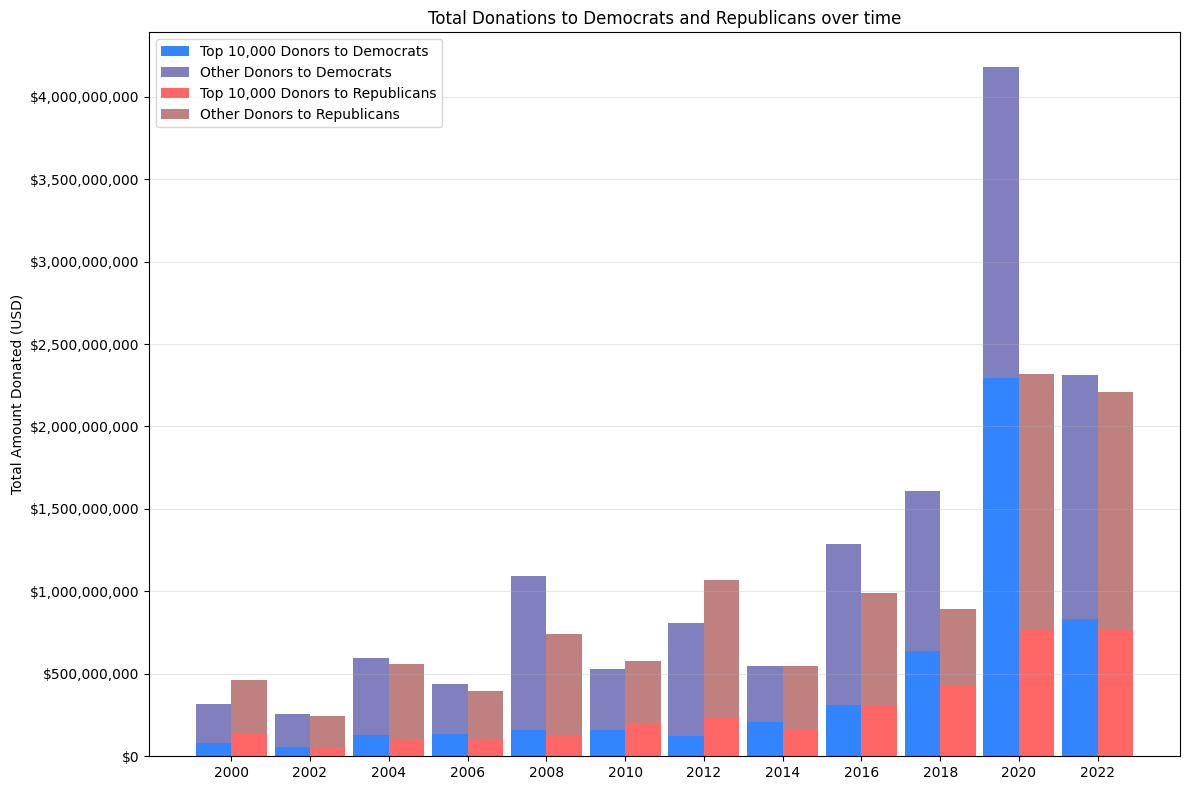

In [15]:
cycle_donations_pivot = cycle_donations.pivot_table(index='cycle', columns='type', values=['D', 'R'])
cycles = sorted(cycle_donations['cycle'].unique())

colors = {
    'Top 10,000 Donors': {'D': '#3385ff', 'R': '#ff6666'},
    'Other Donors': {'D': '#8080BF', 'R': '#BF8080'}
}

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
x_pos = np.arange(len(cycles))
bar_width = 0.45

# Plot each party
for i, party in enumerate(['D', 'R']):
    bottom = np.zeros(len(cycles))
    
    for type_val in ['Top 10,000 Donors', 'Other Donors']:
        values = cycle_donations_pivot[(party, type_val)].reindex(cycles, fill_value=0).values
        ax.bar(x_pos + i * bar_width, values, bar_width, 
               bottom=bottom, color=colors[type_val][party],
               label=f'{party} - {type_val}')
        bottom += values

# Customize plot
ax.set_ylabel('Total Amount Donated (USD)')
ax.set_title('Total Donations to Democrats and Republicans over time')
ax.set_xticks(x_pos + bar_width/2)
ax.set_xticklabels(cycles)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.legend(['Top 10,000 Donors to Democrats', 'Other Donors to Democrats', 'Top 10,000 Donors to Republicans', 'Other Donors to Republicans'], loc='upper left', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
cycle_percentages2 = cycle_donations.copy()

for idx, row in cycle_donations.iterrows():
    cycle = row['cycle']
    party = 'D'
    total_d = cycle_donations[(cycle_donations['cycle'] == cycle)]['D'].sum()
    total_r = cycle_donations[(cycle_donations['cycle'] == cycle)]['R'].sum()
    
    # Calculate percentage share
    cycle_percentages2.at[idx, 'D'] = (row['D'] / total_d * 100) if total_d > 0 else 0
    cycle_percentages2.at[idx, 'R'] = (row['R'] / total_r * 100) if total_r > 0 else 0

cycle_percentages2

party,cycle,type,3,D,I,L,R,U
0,2000,Other Donors,7330584.0,73.692283,723231.0,1329413.0,69.793474,16500.0
1,2000,"Top 10,000 Donors",1695661.0,26.307717,138778.0,248347.0,30.206526,NaN
2,2002,Other Donors,961776.0,77.248506,301776.0,171647.0,80.427239,NaN
3,2002,"Top 10,000 Donors",126200.0,22.751494,188492.0,35309.0,19.572761,NaN
4,2004,Other Donors,4794276.0,78.365800,396669.0,749787.0,81.585885,NaN
5,2004,"Top 10,000 Donors",776181.0,21.634200,1227235.0,68035.0,18.414115,611.0
6,2006,Other Donors,702922.0,68.851386,12896791.0,512038.0,74.580979,950.0
7,2006,"Top 10,000 Donors",172872.0,31.148614,5936709.0,35664.0,25.419021,605.0
8,2008,Other Donors,4030010.0,85.344379,2408843.0,911631.0,83.151856,NaN
9,2008,"Top 10,000 Donors",613572.0,14.655621,290671.0,174253.0,16.848144,70.0


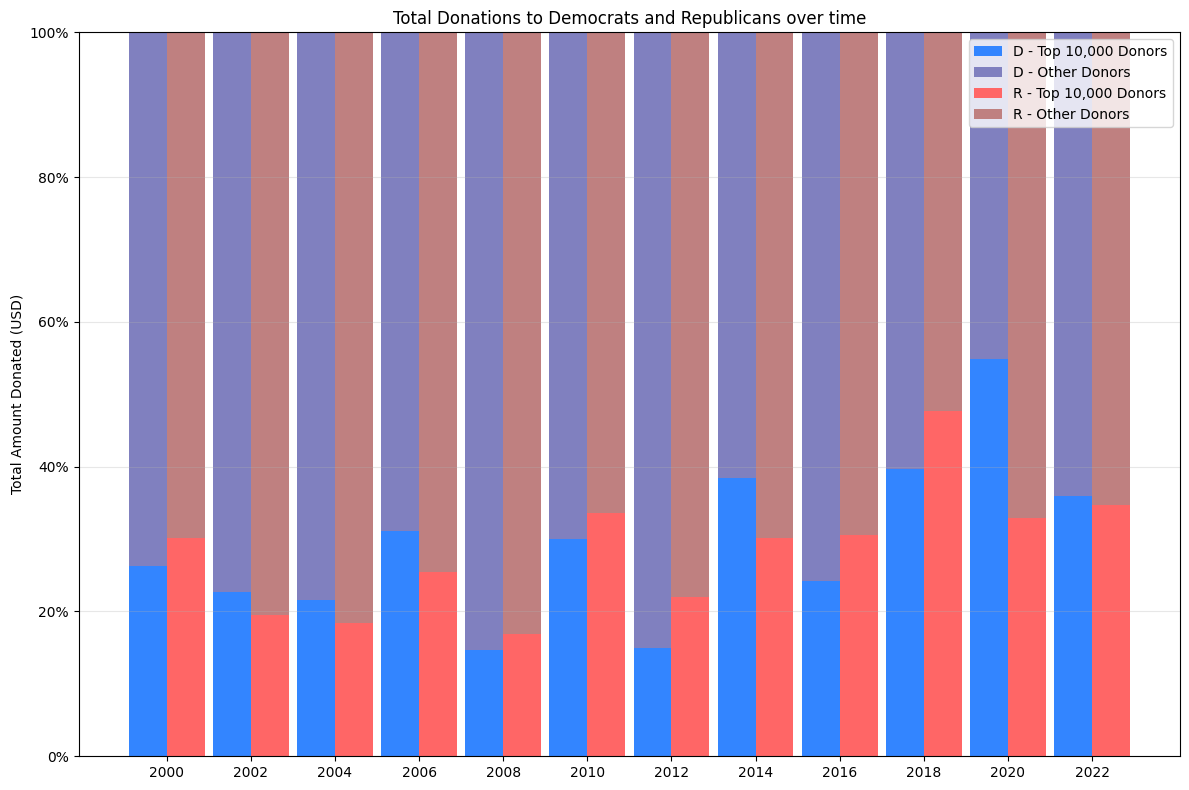

In [17]:
cycle_percentages_pivot = cycle_percentages2.pivot_table(index='cycle', columns='type', values=['D', 'R'])

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
x_pos = np.arange(len(cycles))
bar_width = 0.45

# Plot each party
for i, party in enumerate(['D', 'R']):
    bottom = np.zeros(len(cycles))
    
    for type_val in ['Top 10,000 Donors', 'Other Donors']:
        values = cycle_percentages_pivot[(party, type_val)].reindex(cycles, fill_value=0).values
        ax.bar(x_pos + i * bar_width, values, bar_width, 
               bottom=bottom, color=colors[type_val][party],
               label=f'{party} - {type_val}')
        bottom += values

# Customize plot
ax.set_ylabel('Total Amount Donated (USD)')
ax.set_title('Total Donations to Democrats and Republicans over time')
ax.set_xticks(x_pos + bar_width/2)
ax.set_xticklabels(cycles)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}%'))
ax.set_ylim(0, 100)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
cycle_pac_donations = (donors.groupby(['cycle', 'recip_is_pac', 'party'])['total_donated']
                  .sum()
                  .unstack())
cycle_pac_percentages = cycle_pac_donations.div(cycle_pac_donations.sum(axis=1), axis=0) * 100
cycle_pac_donations = cycle_pac_donations.reset_index()
cycle_pac_donations

party,cycle,recip_is_pac,3,D,I,L,R,U
0,2000,False,9026245.0,3.144031e+08,862009.0,1577760.0,4.606819e+08,16500.0
1,2000,True,NaN,NaN,NaN,NaN,1.312090e+05,NaN
2,2002,False,1087976.0,2.563341e+08,490268.0,206956.0,2.449812e+08,NaN
3,2004,False,5570457.0,5.946197e+08,1623904.0,817822.0,5.618179e+08,611.0
4,2006,False,875794.0,4.396883e+08,18833500.0,547702.0,3.930338e+08,1555.0
5,2008,False,4643582.0,1.092127e+09,2699514.0,1085884.0,7.410971e+08,70.0
6,2010,False,2167522.0,5.281543e+08,15748522.0,466557.0,5.762908e+08,9750.0
7,2012,False,818154.0,8.102432e+08,13154583.0,1373618.0,1.070437e+09,58026.0
8,2012,True,NaN,7.449450e+05,NaN,NaN,NaN,NaN
9,2014,False,618698.0,4.778921e+08,6788217.0,270536.0,5.448615e+08,15335.0


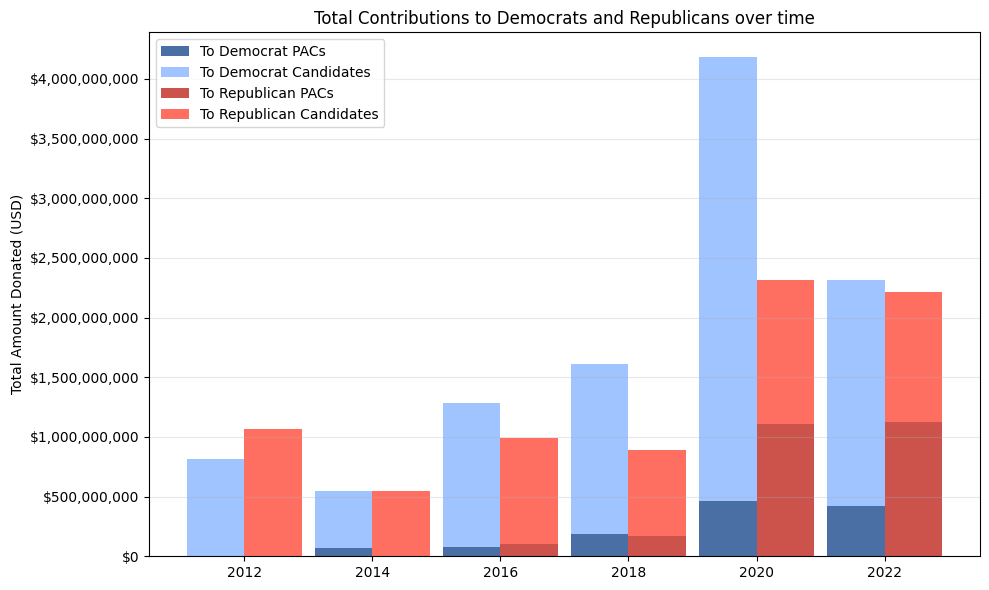

In [19]:
cycle_pac_donations_pivot = cycle_pac_donations.fillna(0).pivot_table(index='cycle', columns='recip_is_pac', values=['D', 'R'])
cycle_pac_donations_pivot = cycle_pac_donations_pivot[cycle_pac_donations_pivot.index >= 2012]
cycles = sorted(cycle_pac_donations['cycle'].unique())
cycles_pac = cycles[cycles.index(2012):]

colors = {
    True: {'D': '#4A6FA5', 'R': '#cc524c'},
    False: {'D': '#A0C4FF', 'R': '#FF6F61'}
}

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(cycles_pac))
bar_width = 0.45

# Plot each party
for i, party in enumerate(['D', 'R']):
    bottom = np.zeros(len(cycles_pac))
    
    for type_val in [True, False]:
        values = cycle_pac_donations_pivot[(party, type_val)].reindex(cycles_pac, fill_value=0).values
        ax.bar(x_pos + i * bar_width, values, bar_width, 
               bottom=bottom, color=colors[type_val][party],
               label=f'{party} - {type_val}')
        bottom += values

# Customize plot
ax.set_ylabel('Total Amount Donated (USD)')
ax.set_title('Total Contributions to Democrats and Republicans over time')
ax.set_xticks(x_pos + bar_width/2)
ax.set_xticklabels(cycles_pac)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.legend(['To Democrat PACs', 'To Democrat Candidates', 'To Republican PACs', 'To Republican Candidates'], loc='upper left', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
donors[(donors["recip_is_pac"] == True) & (~donors["party"].isin(["D", "R"]))]["name_y"].value_counts()[200:220]

name_y
American Assn of Orthodontists          7403
National Apartment Assn                 7374
Warnock Victory Fund                    7368
National Electrical Contractors Assn    7316
Brady PAC                               7282
Democratic Party of Montana             7220
Massachusetts Mutual Life Insurance     7209
California Assn of Realtors             7201
Swift Vets & POWs for Truth             7173
Operating Engineers Union               7153
Republican Party of Illinois            7143
New York State United Teachers          7061
Mortgage Bankers Assn                   7045
Elbert Guillory's America               7043
National Assn of Broadcasters           6965
Missouri Republican State Cmte          6952
Progressive Change Campaign Cmte        6918
Philip A Hart Democratic Club           6917
BNSF Railway                            6886
Democratic Party of South Carolina      6856
Name: count, dtype: int64

In [21]:
# top_donors.drop_duplicates(subset=['contrib_id'], inplace=True)
# top_donors.sort_values(by='total_donated', ascending=False, inplace=True)
# top_donors.to_csv("./output/top_donors_recip_unique.csv", index=False)

In [22]:
donors_avg = donors.groupby(['cycle', 'indian', 'party']).agg(mean=('total_donated', 'mean'), median=('total_donated', 'median')).reset_index()
donors_avg = donors_avg.pivot(index='cycle', columns=['indian', 'party'], values=['mean', 'median']).fillna(0).reset_index()
donors_avg.columns = ['cycle',
                      'mean_other_3', 'mean_other_d', 'mean_other_i', 'mean_other_l', 'mean_other_r','mean_other_u', 
                      'mean_indian_3', 'mean_indian_d', 'mean_indian_i', 'mean_indian_l', 'mean_indian_r','mean_indian_u', 
                      'median_other_3', 'median_other_d', 'median_other_i', 'median_other_l', 'median_other_r','median_other_u', 
                      'median_indian_3', 'median_indian_d', 'median_indian_i', 'median_indian_l', 'median_indian_r','median_indian_u']
donors_avg

,cycle,mean_other_3,mean_other_d,mean_other_i,mean_other_l,mean_other_r,mean_other_u,mean_indian_3,mean_indian_d,mean_indian_i,...,median_other_i,median_other_l,median_other_r,median_other_u,median_indian_3,median_indian_d,median_indian_i,median_indian_l,median_indian_r,median_indian_u
0,2000,756.295176,912.493411,699.722313,731.006993,1019.408337,515.625000,556.900000,764.205197,687.500000,...,500.0,500.0,750.0,475.0,500.0,500.0,750.0,500.0,550.0,0.0
1,2002,976.414722,855.944012,716.864706,678.303030,866.877698,0.000000,250.000000,753.113490,700.000000,...,300.0,400.0,500.0,0.0,250.0,500.0,750.0,500.0,500.0,0.0
2,2004,969.166870,1058.895116,1553.496651,816.603206,1191.098645,611.000000,624.137931,1015.060654,500.000000,...,300.0,500.0,1000.0,611.0,500.0,500.0,500.0,401.0,1000.0,0.0
3,2006,879.131181,1174.627828,1534.432185,1171.771552,1241.085740,388.750000,653.571429,1078.596210,1303.611940,...,1000.0,500.0,750.0,375.0,500.0,501.0,1000.0,500.0,500.0,0.0
4,2008,1055.278655,1235.813973,897.200806,854.561655,1360.697616,70.000000,1146.629630,1248.591061,953.448276,...,300.0,500.0,950.0,70.0,600.0,708.0,300.0,1000.0,1000.0,0.0
5,2010,1238.611271,1300.169763,1505.449280,2111.117647,1324.261603,1950.000000,2262.833333,1234.237047,1589.648045,...,750.0,500.0,500.0,1000.0,1750.0,500.0,1000.0,0.0,500.0,0.0
6,2012,643.573482,1128.155851,2375.060239,878.314672,1442.811387,1031.714286,652.631579,1118.616053,701.388889,...,500.0,500.0,500.0,500.0,250.0,500.0,500.0,500.0,500.0,250.0
7,2014,3637.929412,1642.554006,1974.321082,1213.165919,1475.193762,1330.454545,250.000000,1490.324304,1501.040816,...,500.0,500.0,750.0,500.0,250.0,750.0,1000.0,0.0,765.0,700.0
8,2016,651.402337,1038.331661,1049.819739,552.384503,1012.382194,2051.333333,721.247312,1290.539600,1085.488372,...,350.0,250.0,250.0,1005.0,500.0,500.0,500.0,250.0,500.0,0.0
9,2018,1416.781109,1508.522531,980.579887,1440.096647,1774.623269,0.000000,634.666667,1560.695638,61781.202532,...,250.0,500.0,500.0,0.0,285.5,755.0,410.0,150.0,750.0,0.0


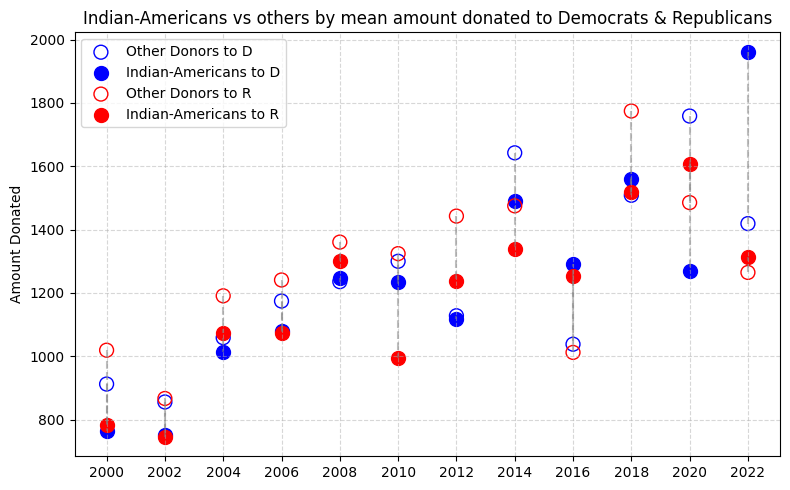

In [23]:
plt.figure(figsize=(8, 5))

cycles = pd.Series(donors_avg["cycle"]).apply(lambda x: str(x)[:4])
for cat, g1, g2 in zip(cycles, donors_avg["mean_other_d"], donors_avg["mean_indian_d"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(cycles, donors_avg["mean_other_r"], donors_avg["mean_indian_r"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(cycles, donors_avg["mean_other_d"], facecolors='none', edgecolors='blue', color='blue', label='Other Donors to D', s=100)
plt.scatter(cycles, donors_avg["mean_indian_d"], color='blue', label='Indian-Americans to D', s=100)
plt.scatter(cycles, donors_avg["mean_other_r"], facecolors='none', edgecolors='red', label='Other Donors to R', s=100)
plt.scatter(cycles, donors_avg["mean_indian_r"], color='red', label='Indian-Americans to R', s=100)

plt.title(f"Indian-Americans vs others by mean amount donated to Democrats & Republicans")
plt.ylabel("Amount Donated")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

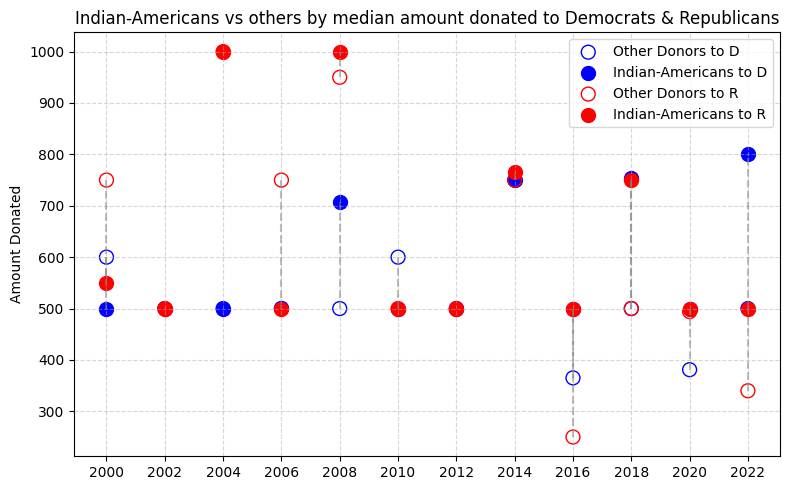

In [24]:
plt.figure(figsize=(8, 5))

cycles = pd.Series(donors_avg["cycle"]).apply(lambda x: str(x)[:4])
for cat, g1, g2 in zip(cycles, donors_avg["median_other_d"], donors_avg["median_indian_d"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(cycles, donors_avg["median_other_r"], donors_avg["median_indian_r"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(cycles, donors_avg["median_other_d"], facecolors='none', edgecolors='blue', color='blue', label='Other Donors to D', s=100)
plt.scatter(cycles, donors_avg["median_indian_d"], color='blue', label='Indian-Americans to D', s=100)
plt.scatter(cycles, donors_avg["median_other_r"], facecolors='none', edgecolors='red', label='Other Donors to R', s=100)
plt.scatter(cycles, donors_avg["median_indian_r"], color='red', label='Indian-Americans to R', s=100)

plt.title(f"Indian-Americans vs others by median amount donated to Democrats & Republicans")
plt.ylabel("Amount Donated")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [25]:
sectors_avg = donors[(donors["cycle"] == 2000 + year) & (~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"]))].groupby(['sector', 'indian', 'party']).agg(mean=('total_donated', 'mean'), median=('total_donated', 'median')).reset_index()
sectors_avg = sectors_avg.pivot(index='sector', columns=['indian', 'party'], values=['mean', 'median']).fillna(0).reset_index()
sectors_avg.columns = ['sector',
                      'mean_other_3', 'mean_other_d', 'mean_other_i', 'mean_other_l', 'mean_other_r',
                      'mean_indian_d', 'mean_indian_i', 'mean_indian_r', 'mean_other_u', 'mean_indian_3','mean_indian_l', 
                      'median_other_3', 'median_other_d', 'median_other_i', 'median_other_l', 'median_other_r', 
                      'median_indian_d', 'median_indian_i', 'median_indian_r', 'median_other_u', 'median_indian_3','median_indian_l']
sectors_avg

,sector,mean_other_3,mean_other_d,mean_other_i,mean_other_l,mean_other_r,mean_indian_d,mean_indian_i,mean_indian_r,mean_other_u,...,median_other_d,median_other_i,median_other_l,median_other_r,median_indian_d,median_indian_i,median_indian_r,median_other_u,median_indian_3,median_indian_l
0,Agribusiness,504.000000,895.233524,440.705069,295.000000,1562.224807,1069.336957,386.083333,1627.088235,0.000000,...,300.0,189.0,250.0,500.0,500.0,163.5,507.0,0.0,0.0,0.0
1,Construction,712.080000,855.188859,444.967114,1463.877193,1422.935887,1272.605714,785.068182,1902.725888,273.000000,...,275.0,190.0,250.0,500.0,500.0,248.0,962.0,273.0,0.0,0.0
2,Defense,156.000000,727.385141,550.790161,351.200000,1400.086232,2015.528090,490.117647,706.600000,0.000000,...,299.0,212.0,200.0,500.0,353.0,200.0,500.0,0.0,250.0,0.0
3,Energy,249.777778,1138.275749,515.852604,375.075000,1973.551886,1056.236735,290.720000,1434.027027,1600.000000,...,375.0,201.0,250.0,711.0,500.0,200.0,500.0,1600.0,1037.0,0.0
4,Finance,1102.987342,2033.590235,559.329311,1025.774869,3339.042738,3108.394689,465.566879,2515.987897,0.000000,...,500.0,204.0,300.0,700.0,1000.0,196.0,945.0,0.0,500.0,0.0
5,Health,721.478528,766.619635,484.790265,506.119048,1380.668608,983.035253,608.781553,1756.088142,0.000000,...,250.0,199.0,250.0,474.0,500.0,230.5,594.0,0.0,2800.0,300.0
6,Labor,280.000000,578.930791,425.234192,205.000000,746.890999,633.142857,440.222222,646.200000,0.000000,...,250.0,193.0,150.0,300.0,250.0,217.0,750.0,0.0,0.0,0.0
7,Law,1236.757576,1361.501217,683.581665,626.512500,1457.472372,1396.029104,763.903226,1150.604651,0.000000,...,500.0,275.0,250.0,650.0,666.0,293.0,500.0,0.0,575.0,2875.0
8,Manufacturing,946.625000,1055.437466,418.102118,1383.943396,2732.522432,2086.691489,808.473684,1951.795455,0.000000,...,299.5,189.0,335.0,650.0,750.0,231.0,875.5,0.0,0.0,0.0
9,Tech,618.239130,1503.172706,600.644218,642.918919,1549.178724,1055.353695,732.377171,1151.126246,1288.666667,...,334.0,225.0,250.0,500.0,450.0,262.0,500.0,1000.0,0.0,201.0


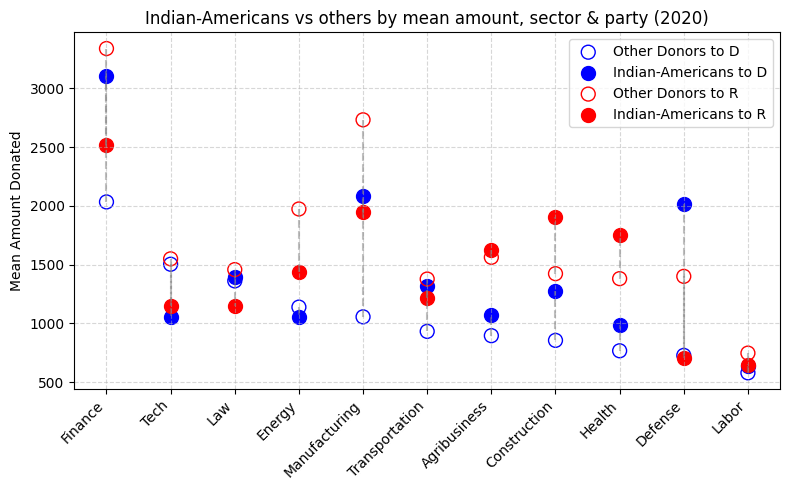

In [26]:
plt.figure(figsize=(8, 5))

sectors_avg = sectors_avg.sort_values(by='mean_other_d', ascending=False)
sectors = sectors_avg["sector"].tolist()

for cat, g1, g2 in zip(sectors, sectors_avg["mean_other_d"], sectors_avg["mean_indian_d"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(sectors, sectors_avg["mean_other_r"], sectors_avg["mean_indian_r"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, sectors_avg["mean_other_d"], facecolors='none', edgecolors='blue', label='Other Donors to D', s=100)
plt.scatter(sectors, sectors_avg["mean_indian_d"], color='blue', label='Indian-Americans to D', s=100)
plt.scatter(sectors, sectors_avg["mean_other_r"], facecolors='none', edgecolors='red', label='Other Donors to R', s=100)
plt.scatter(sectors, sectors_avg["mean_indian_r"], color='red', label='Indian-Americans to R', s=100)

plt.title(f"Indian-Americans vs others by mean amount, sector & party (20{year})")
plt.ylabel("Mean Amount Donated")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

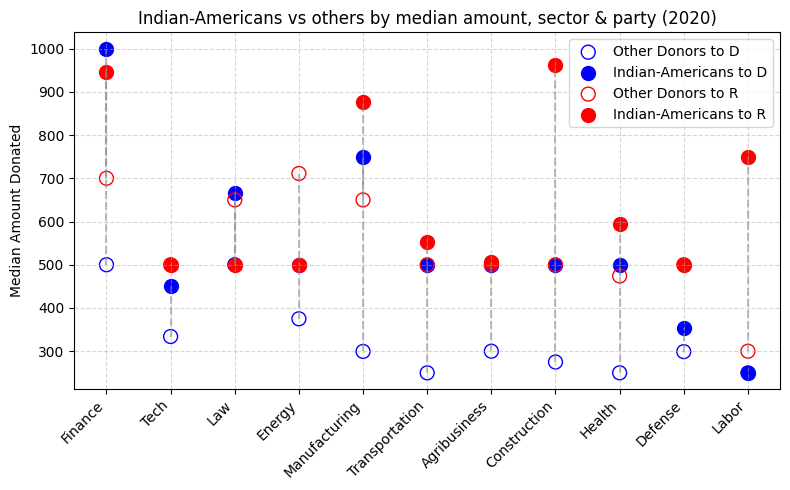

In [27]:
plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, sectors_avg["median_other_d"], sectors_avg["median_indian_d"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(sectors, sectors_avg["median_other_r"], sectors_avg["median_indian_r"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, sectors_avg["median_other_d"], facecolors='none', edgecolors='blue', label='Other Donors to D', s=100)
plt.scatter(sectors, sectors_avg["median_indian_d"], color='blue', label='Indian-Americans to D', s=100)
plt.scatter(sectors, sectors_avg["median_other_r"], facecolors='none', edgecolors='red', label='Other Donors to R', s=100)
plt.scatter(sectors, sectors_avg["median_indian_r"], color='red', label='Indian-Americans to R', s=100)

plt.title(f"Indian-Americans vs others by median amount, sector & party (20{year})")
plt.ylabel("Median Amount Donated")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [28]:
# statistical tests

model = ols('total_donated ~ C(indian) + C(sector) + cycle', data=donors).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq          df          F        PR(>F)
C(indian)  6.427925e+09         1.0   0.099848  7.520122e-01
C(sector)  1.172516e+13        13.0  14.010184  6.231110e-32
cycle      4.513125e+11         1.0   7.010446  8.103556e-03
Residual   1.569582e+18  24381042.0        NaN           NaN


In [29]:
tukey = pairwise_tukeyhsd(endog=donors[(donors["total_donated"].notnull())]['total_donated'],
                         groups=donors[(donors["total_donated"].notnull())]['indian'],
                         alpha=0.05)
print(tukey.summary())

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
 False   True  -65.726 0.8615 -803.9104 672.4583  False
-------------------------------------------------------


In [30]:
# donors["dollar_lean"] = donors.apply(lambda x: x["total_donated"] * -1 if x["party"] == "R" else x["total_donated"] * 0 if x["party"] not in ["D", "R"] else x["total_donated"], axis=1)
donors['dollar_lean'] = np.select([donors['party'] == 'R', ~donors['party'].isin(['D', 'R'])], [donors['total_donated'] * -1, 0], default=donors['total_donated'])

donors_lean = donors[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])].groupby(['cycle', 'indian', 'sector']).agg(lean=('dem_ratio', 'mean'), dollar_lean=('dollar_lean', 'sum'), total=('total_donated', 'sum')).reset_index()
donors_lean["dollar_lean"] = donors_lean["dollar_lean"] / donors_lean["total"]

donors_lean = donors_lean.pivot(index=['cycle', 'sector'], columns='indian', values=['lean', 'dollar_lean']).fillna(0).reset_index()
donors_lean.columns = ["cycle", 'sector', 'lean_other', 'lean_indian', 'dollar_lean_other', 'dollar_lean_indian']
donors_lean

,cycle,sector,lean_other,lean_indian,dollar_lean_other,dollar_lean_indian
0,2000,Agribusiness,-0.469116,-0.257143,-0.206997,-0.223806
1,2000,Construction,-0.377104,0.123546,-0.192782,0.047022
2,2000,Defense,-0.287838,0.096774,-0.161721,0.142431
3,2000,Energy,-0.508510,0.074177,-0.200370,0.037760
4,2000,Finance,-0.245861,0.129340,-0.091254,0.098863
...,...,...,...,...,...,...
127,2022,Labor,0.518101,0.696970,0.034725,0.118182
128,2022,Law,0.380793,0.621227,0.214890,0.334286
129,2022,Manufacturing,-0.291933,0.573621,-0.086896,0.445630
130,2022,Tech,0.536249,0.681900,0.191621,0.395733


In [31]:
donors_pac_lean = donors[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])].groupby(['cycle', 'indian', 'sector', 'level']).agg(lean=('dem_ratio', 'mean'), dollar_lean=('dollar_lean', 'sum'), total=('total_donated', 'sum')).reset_index()
donors_pac_lean["dollar_lean"] = donors_pac_lean["dollar_lean"] / donors_pac_lean["total"]

donors_pac_lean = donors_pac_lean.pivot(index=['cycle', 'sector', 'level'], columns='indian', values=['lean', 'dollar_lean']).fillna(0).reset_index()
donors_pac_lean.columns = ["cycle", 'sector', 'level', 'lean_other', 'lean_indian', 'dollar_lean_other', 'dollar_lean_indian']
donors_pac_lean

,cycle,sector,level,lean_other,lean_indian,dollar_lean_other,dollar_lean_indian
0,2000,Agribusiness,House,-0.410636,-0.180952,-0.391971,-0.178392
1,2000,Agribusiness,PAC,-0.517375,0.111111,0.000000,0.000000
2,2000,Agribusiness,President,-0.642367,-0.714286,-0.674355,-0.904762
3,2000,Construction,House,-0.328470,0.126309,-0.308521,0.120287
4,2000,Construction,PAC,-0.471285,0.321268,0.000000,0.000000
...,...,...,...,...,...,...,...
484,2022,Tech,Unknown,0.222222,0.000000,0.000000,0.000000
485,2022,Transportation,House,-0.172232,0.275952,-0.284706,0.420554
486,2022,Transportation,PAC,-0.632181,-0.219719,-0.086110,-0.055213
487,2022,Transportation,President,0.738240,0.800000,0.001602,0.310067


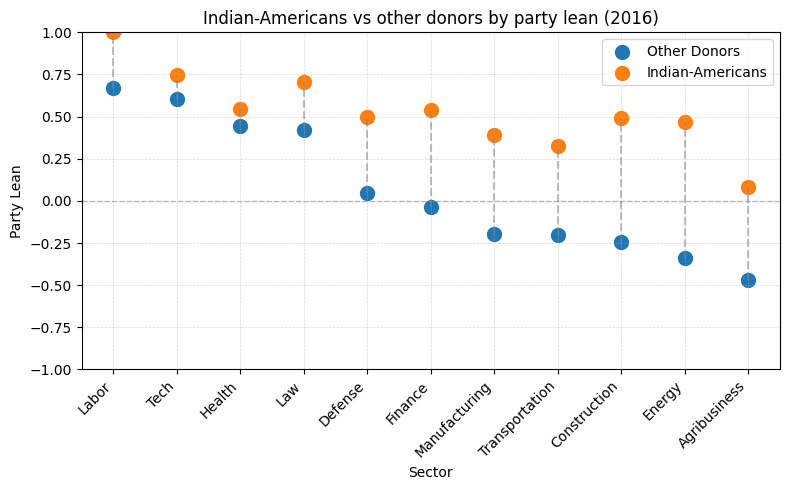

In [32]:
donors_lean_year = donors_lean[donors_lean["cycle"] == 2000 + 16].sort_values(by="lean_other", ascending=False)
sectors = donors_lean_year["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year["lean_other"], donors_lean_year["lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year["lean_other"], cmap="coolwarm_r", label='Other Donors', s=100)
plt.scatter(sectors, donors_lean_year["lean_indian"], cmap="coolwarm_r", label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (20{16})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

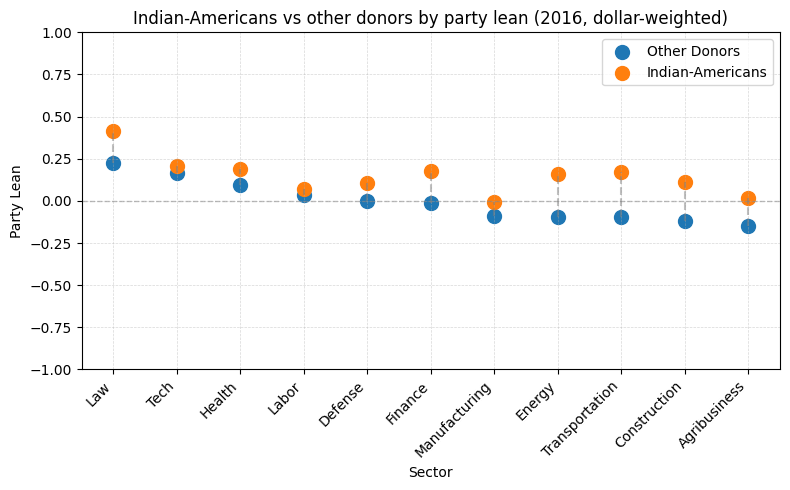

In [33]:
donors_lean_year = donors_lean[donors_lean["cycle"] == 2000 + 16].sort_values(by="dollar_lean_other", ascending=False)
sectors = donors_lean_year["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year["dollar_lean_other"], donors_lean_year["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year["dollar_lean_other"], cmap="coolwarm_r", label='Other Donors', s=100)
plt.scatter(sectors, donors_lean_year["dollar_lean_indian"], cmap="coolwarm_r", label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (20{16}, dollar-weighted)")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

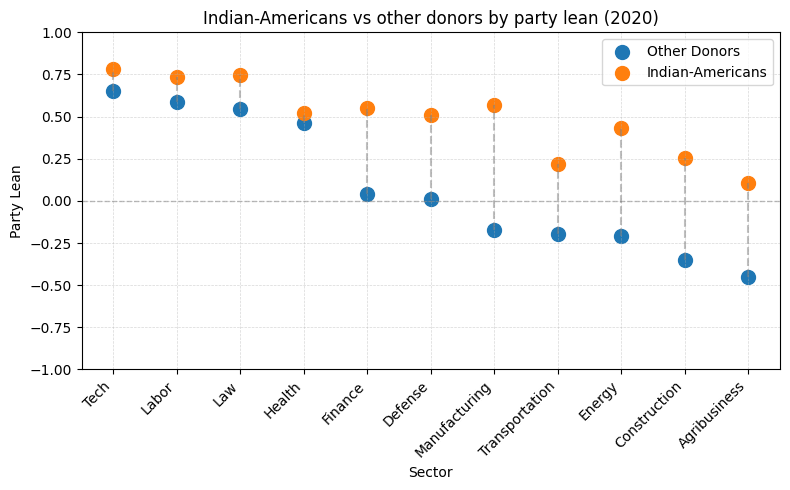

In [34]:
donors_lean_year = donors_lean[donors_lean["cycle"] == 2000 + year].sort_values(by="lean_other", ascending=False)
sectors = donors_lean_year["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year["lean_other"], donors_lean_year["lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year["lean_other"], cmap="coolwarm_r", label='Other Donors', s=100)
plt.scatter(sectors, donors_lean_year["lean_indian"], cmap="coolwarm_r", label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (20{year})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

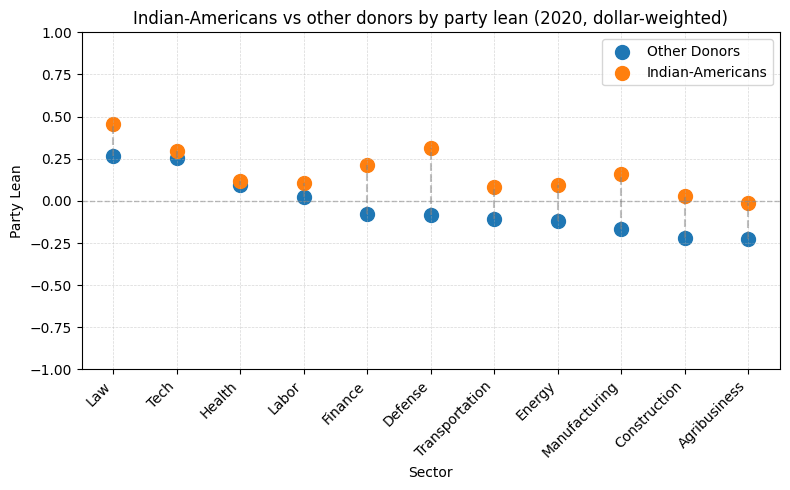

In [35]:
donors_lean_year = donors_lean[donors_lean["cycle"] == 2000 + year].sort_values(by="dollar_lean_other", ascending=False)
sectors = donors_lean_year["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year["dollar_lean_other"], donors_lean_year["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year["dollar_lean_other"], cmap="coolwarm_r", label='Other Donors', s=100)
plt.scatter(sectors, donors_lean_year["dollar_lean_indian"], cmap="coolwarm_r", label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (20{year}, dollar-weighted)")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

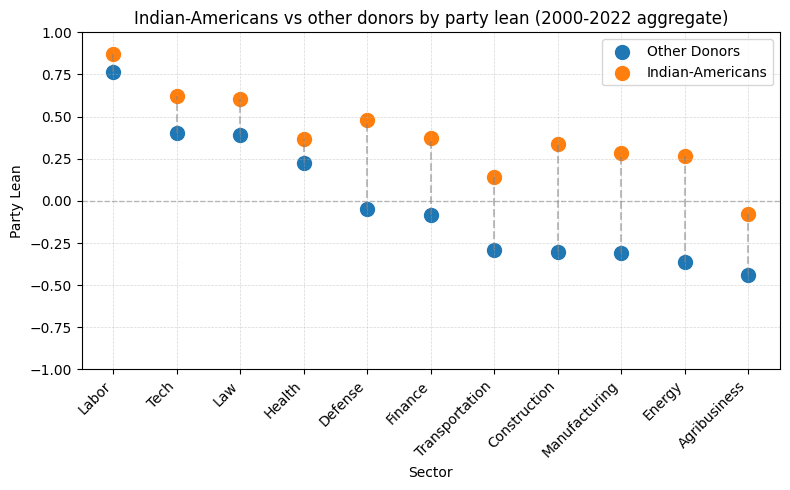

In [36]:
donors_lean_year = donors_lean.groupby(['sector']).agg(lean_other=('lean_other', 'mean'), lean_indian=('lean_indian', 'mean')).reset_index().sort_values(by="lean_other", ascending=False)
sectors = donors_lean_year["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year["lean_other"], donors_lean_year["lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year["lean_other"], cmap="coolwarm_r", label='Other Donors', s=100)
plt.scatter(sectors, donors_lean_year["lean_indian"], cmap="coolwarm_r", label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (2000-2022 aggregate)")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

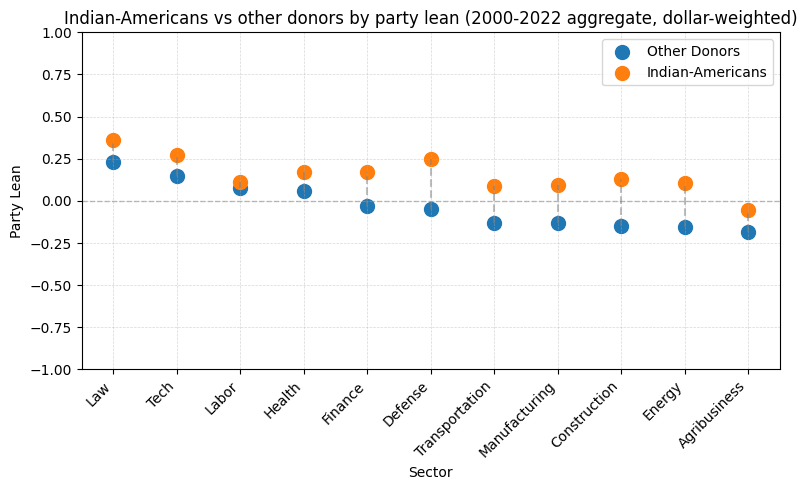

In [37]:
donors_lean_year = donors_lean.groupby(['sector']).agg(lean_other=('lean_other', 'mean'), lean_indian=('lean_indian', 'mean'), dollar_lean_other=('dollar_lean_other', 'mean'), dollar_lean_indian=('dollar_lean_indian', 'mean')).reset_index().sort_values(by="dollar_lean_other", ascending=False)
sectors = donors_lean_year["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year["dollar_lean_other"], donors_lean_year["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year["dollar_lean_other"], cmap="coolwarm_r", label='Other Donors', s=100)
plt.scatter(sectors, donors_lean_year["dollar_lean_indian"], cmap="coolwarm_r", label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (2000-2022 aggregate, dollar-weighted)")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

In [38]:
# statistical tests

model = ols('dem_ratio ~ C(indian) + C(sector) + cycle', data=donors).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq          df             F  PR(>F)
C(indian)  2.564654e+04         1.0  29044.732310     0.0
C(sector)  1.046153e+06        13.0  91136.084083     0.0
cycle      2.693787e+04         1.0  30507.160466     0.0
Residual   1.566562e+07  17741327.0           NaN     NaN


In [39]:
tukey = pairwise_tukeyhsd(endog=donors[(donors["dem_ratio"].notnull())]['dem_ratio'],
                         groups=donors[(donors["dem_ratio"].notnull())]['indian'],
                         alpha=0.05)
print(tukey.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
 False   True   0.3738   0.0 0.3701 0.3776   True
-------------------------------------------------


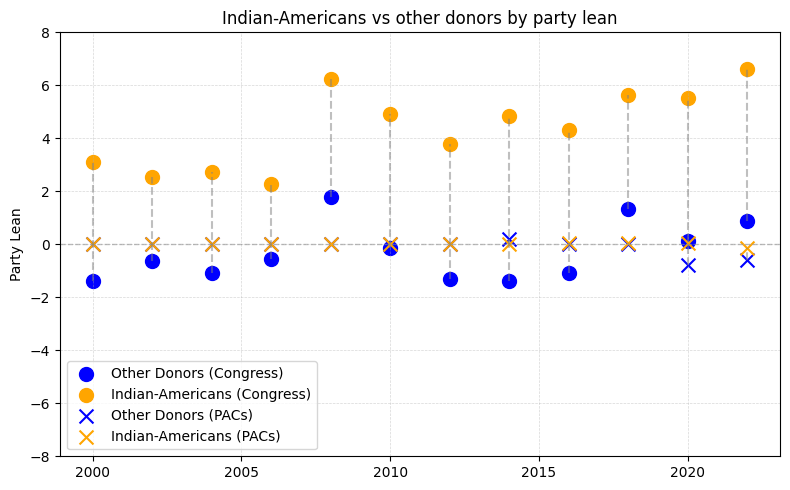

In [40]:
# this needs to be fixed by aggregating cycle averages correctly (currently sums party leans of each sector instead of calculating dollar weighted lean)
# also, the "regular" party lean needs to be fixed because it's at the level of donations, not donors

donors_lean_yearly = donors_pac_lean.groupby(["cycle", "level"]).sum().sort_values(by="cycle", ascending=True).reset_index()
cycles = donors_lean_yearly[donors_lean_yearly["level"] == "President"]["cycle"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(cycles, donors_lean_yearly[donors_lean_yearly["level"] == "House"]["dollar_lean_other"], donors_lean_yearly[donors_lean_yearly["level"] == "House"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(cycles, donors_lean_yearly[donors_lean_yearly["level"] == "PAC"]["dollar_lean_other"], donors_lean_yearly[donors_lean_yearly["level"] == "PAC"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(cycles, donors_lean_yearly[donors_lean_yearly["level"] == "House"]["dollar_lean_other"], color="blue", label='Other Donors (Congress)', s=100)
plt.scatter(cycles, donors_lean_yearly[donors_lean_yearly["level"] == "House"]["dollar_lean_indian"], color="orange",  label='Indian-Americans (Congress)', s=100)
plt.scatter(cycles, donors_lean_yearly[donors_lean_yearly["level"] == "PAC"]["dollar_lean_other"], marker="x", color="blue", label='Other Donors (PACs)', s=100)
plt.scatter(cycles, donors_lean_yearly[donors_lean_yearly["level"] == "PAC"]["dollar_lean_indian"], marker="x", color="orange",  label='Indian-Americans (PACs)', s=100)

plt.title(f"Indian-Americans vs other donors by party lean")
plt.ylabel("Party Lean")
plt.ylim(-8, 8)

plt.legend(loc='lower left')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

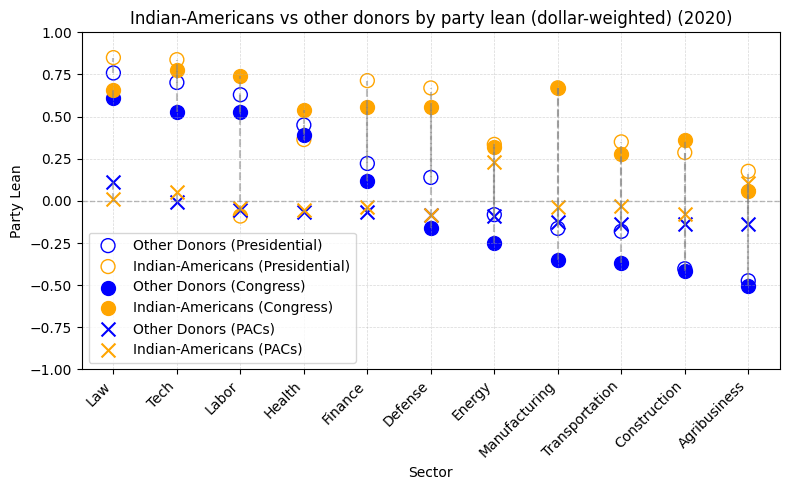

In [41]:
donors_lean_year = donors_pac_lean[donors_pac_lean["cycle"] == 2000 + year].sort_values(by="dollar_lean_other", ascending=False)
sectors = donors_lean_year[donors_lean_year["level"] == "President"]["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_other"], donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(sectors, donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_other"], donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(sectors, donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_other"], donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_other"], facecolors='none', edgecolors='blue', label='Other Donors (Presidential)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_indian"], facecolors='none', edgecolors='orange', label='Indian-Americans (Presidential)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_other"], color="blue", label='Other Donors (Congress)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_indian"], color="orange",  label='Indian-Americans (Congress)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_other"], marker="x", color="blue", label='Other Donors (PACs)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_indian"], marker="x", color="orange",  label='Indian-Americans (PACs)', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (dollar-weighted) (20{year})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

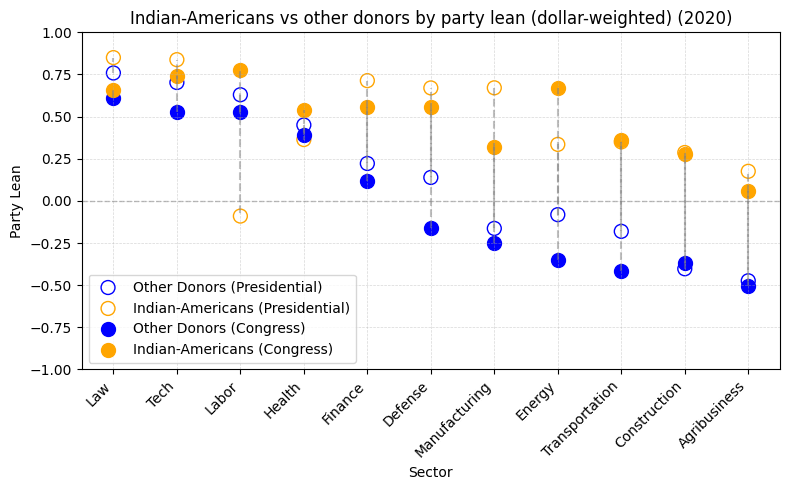

In [42]:
donors_lean_year = donors_pac_lean[donors_pac_lean["cycle"] == 2000 + year].sort_values(by="lean_other", ascending=False)
sectors = donors_lean_year[donors_lean_year["level"] == "President"]["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_other"], donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(sectors, donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_other"], donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_other"], facecolors='none', edgecolors='blue', label='Other Donors (Presidential)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_indian"], facecolors='none', edgecolors='orange', label='Indian-Americans (Presidential)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_other"], color="blue", label='Other Donors (Congress)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_indian"], color="orange",  label='Indian-Americans (Congress)', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (dollar-weighted) (20{year})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

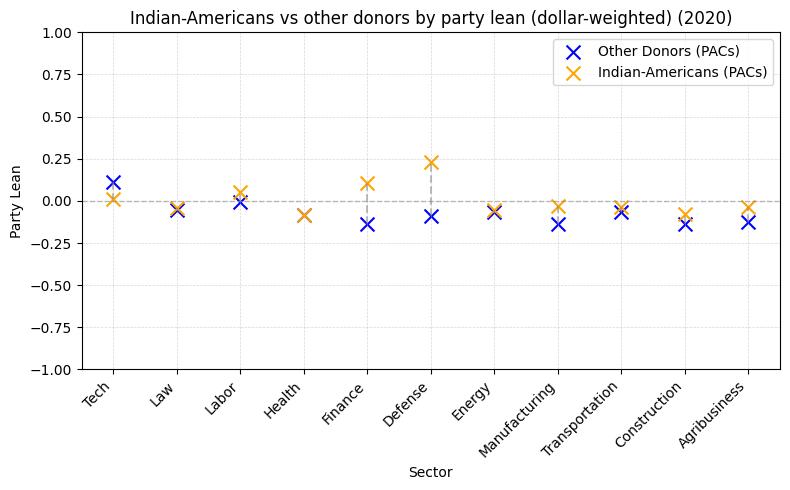

In [43]:
donors_lean_year = donors_pac_lean[donors_pac_lean["cycle"] == 2000 + year].sort_values(by="lean_other", ascending=False)
sectors = donors_lean_year[donors_lean_year["level"] == "PAC"]["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_other"], donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_other"], marker="x", color="blue", label='Other Donors (PACs)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_indian"], marker="x", color="orange",  label='Indian-Americans (PACs)', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (dollar-weighted) (20{year})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

In [44]:
print("Overall, presidential: ", donors_pac_lean[(donors_pac_lean["cycle"] == 2000 + year) & (donors_pac_lean["level"] == "President")]["dollar_lean_other"].mean())
print("Indians, presidential: ", donors_pac_lean[(donors_pac_lean["cycle"] == 2000 + year) & (donors_pac_lean["level"] == "President")]["dollar_lean_indian"].mean())
print("Overall, congressional: ", donors_pac_lean[(donors_pac_lean["cycle"] == 2000 + year) & (donors_pac_lean["level"] == "House")]["dollar_lean_other"].mean())
print("Indians, congressional: ", donors_pac_lean[(donors_pac_lean["cycle"] == 2000 + year) & (donors_pac_lean["level"] == "House")]["dollar_lean_indian"].mean())
print("Overall, PAC: ", donors_pac_lean[(donors_pac_lean["cycle"] == 2000 + year) & (donors_pac_lean["level"] == "PAC")]["dollar_lean_other"].mean())
print("Indians, PAC: ", donors_pac_lean[(donors_pac_lean["cycle"] == 2000 + year) & (donors_pac_lean["level"] == "PAC")]["dollar_lean_indian"].mean())

Overall, presidential:  0.1455451639604563
Indians, presidential:  0.469533863032137
Overall, congressional:  0.010594387938757978
Indians, congressional:  0.5018695108347638
Overall, PAC:  -0.07180083953653019
Indians, PAC:  0.00415028629431664


In [45]:
sectors_count = donors[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])].groupby(['cycle', 'sector', 'indian', 'party']).agg(sum=('total_donated', 'sum'), count=('contrib_id', 'count')).reset_index()
sectors_count_pivot = sectors_count.pivot(index=['cycle', 'sector'], columns=['indian', 'party'], values=['sum', 'count']).fillna(0).reset_index()
sectors_count_pivot.columns = ['cycle', 'sector',
                      'sum_other_3', 'sum_other_d', 'sum_other_i', 'sum_other_l', 'sum_other_r',
                      'sum_indian_d', 'sum_indian_r', 'sum_indian_3', 'sum_other_u', 'sum_indian_l','sum_indian_i', 'sum_indian_u', 
                      'count_other_3', 'count_other_d', 'count_other_i', 'count_other_l', 'count_other_r', 
                      'count_indian_d', 'count_indian_r', 'count_indian_3', 'count_other_u', 'count_indian_l','count_indian_i', 'count_indian_u']
sectors_count_pivot[['cycle', 'sector', 'sum_other_d', 'sum_indian_d', 'sum_other_r', 'sum_indian_r', 'count_other_d', 'count_indian_d', 'count_other_r', 'count_indian_r']]

,cycle,sector,sum_other_d,sum_indian_d,sum_other_r,sum_indian_r,count_other_d,count_indian_d,count_other_r,count_indian_r
0,2000,Agribusiness,3398157.0,17100.0,9380760.0,38450.0,4536.0,24.0,12235.0,45.0
1,2000,Construction,9558329.0,140641.0,20287405.0,119601.0,10728.0,158.0,22881.0,130.0
2,2000,Defense,967617.0,14166.0,1701795.0,9200.0,1216.0,15.0,2184.0,13.0
3,2000,Energy,3531673.0,52550.0,10750955.0,46050.0,4261.0,56.0,12359.0,48.0
4,2000,Finance,45497965.0,345102.0,71193063.0,232801.0,48164.0,392.0,78189.0,297.0
...,...,...,...,...,...,...,...,...,...,...
127,2022,Labor,2672786.0,28787.0,497269.0,2500.0,3152.0,18.0,902.0,4.0
128,2022,Law,132130108.0,1247259.0,59223286.0,252462.0,71435.0,586.0,33144.0,135.0
129,2022,Manufacturing,10295884.0,1183705.0,27065891.0,105037.0,5808.0,255.0,9396.0,64.0
130,2022,Tech,110535326.0,2451784.0,33165545.0,365919.0,48104.0,1189.0,13649.0,227.0


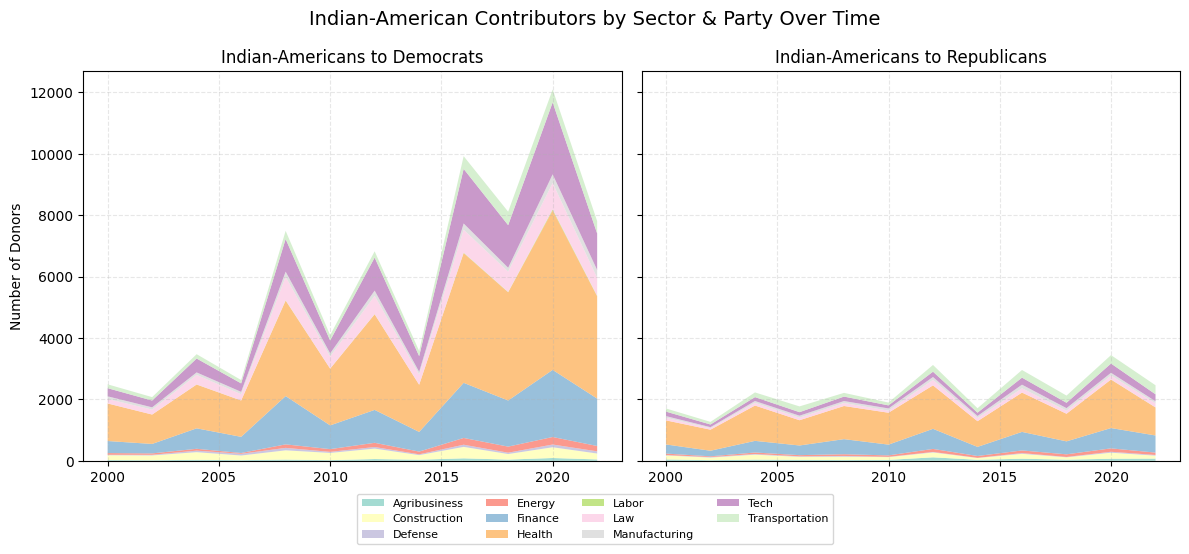

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sectors = sectors_count_pivot["sector"].unique()
colors = sns.color_palette("Set3", n_colors=len(sectors))

count_indian_d = sectors_count_pivot.pivot(index='cycle', columns='sector', values='count_indian_d')
count_indian_r = sectors_count_pivot.pivot(index='cycle', columns='sector', values='count_indian_r')

ax1.stackplot(
    count_indian_d.index,
    count_indian_d.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Indian-Americans to Democrats", fontsize=12)
ax1.set_ylabel("Number of Donors")
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    count_indian_r.index,
    count_indian_r.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Indian-American Contributors by Sector & Party Over Time", fontsize=14)
plt.tight_layout()
plt.show()

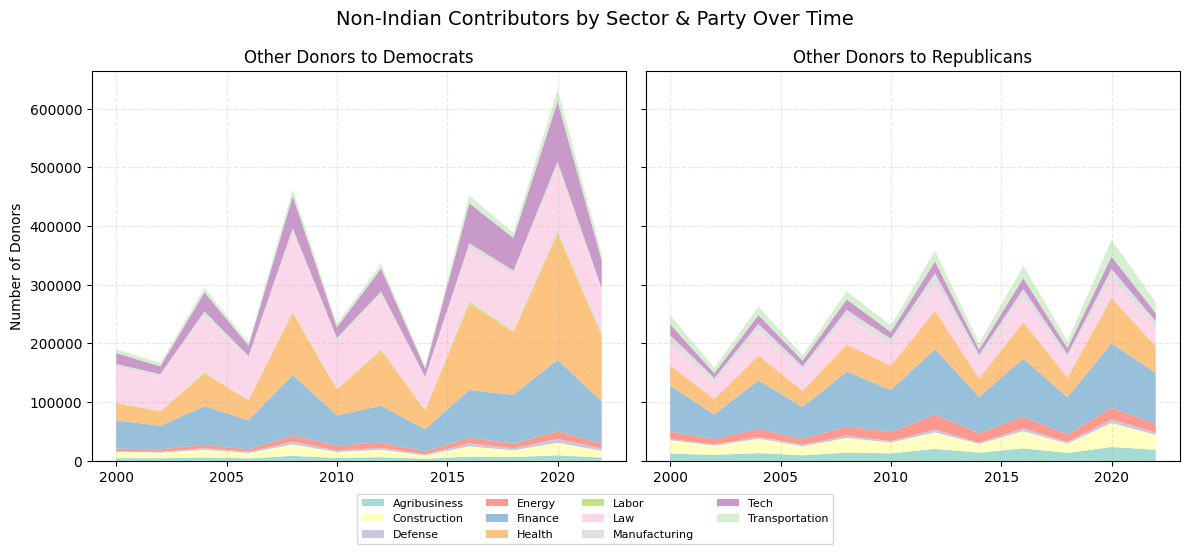

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

count_other_d = sectors_count_pivot.pivot(index='cycle', columns='sector', values='count_other_d')
count_other_r = sectors_count_pivot.pivot(index='cycle', columns='sector', values='count_other_r')

ax1.stackplot(
    count_other_d.index,
    count_other_d.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Other Donors to Democrats", fontsize=12)
ax1.set_ylabel("Number of Donors")
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    count_other_r.index,
    count_other_r.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Other Donors to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Non-Indian Contributors by Sector & Party Over Time", fontsize=14)
plt.tight_layout()
plt.show()

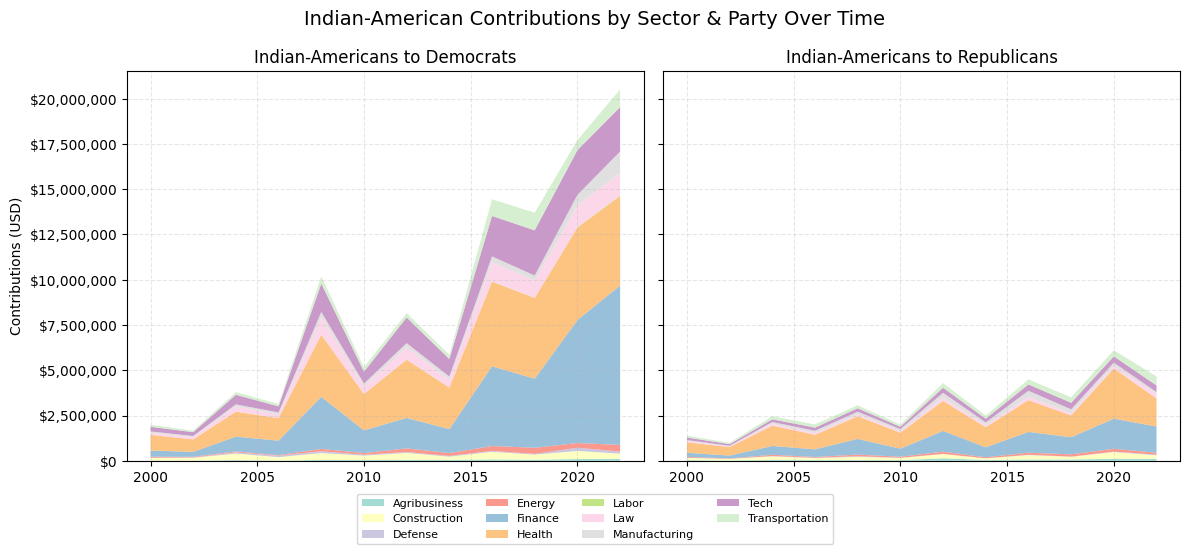

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sum_indian_d = sectors_count_pivot.pivot(index='cycle', columns='sector', values='sum_indian_d')
sum_indian_r = sectors_count_pivot.pivot(index='cycle', columns='sector', values='sum_indian_r')

ax1.stackplot(
    sum_indian_d.index,
    sum_indian_d.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Indian-Americans to Democrats", fontsize=12)
ax1.set_ylabel("Contributions (USD)")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    sum_indian_r.index,
    sum_indian_r.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Indian-American Contributions by Sector & Party Over Time", fontsize=14)
plt.tight_layout()
plt.show()

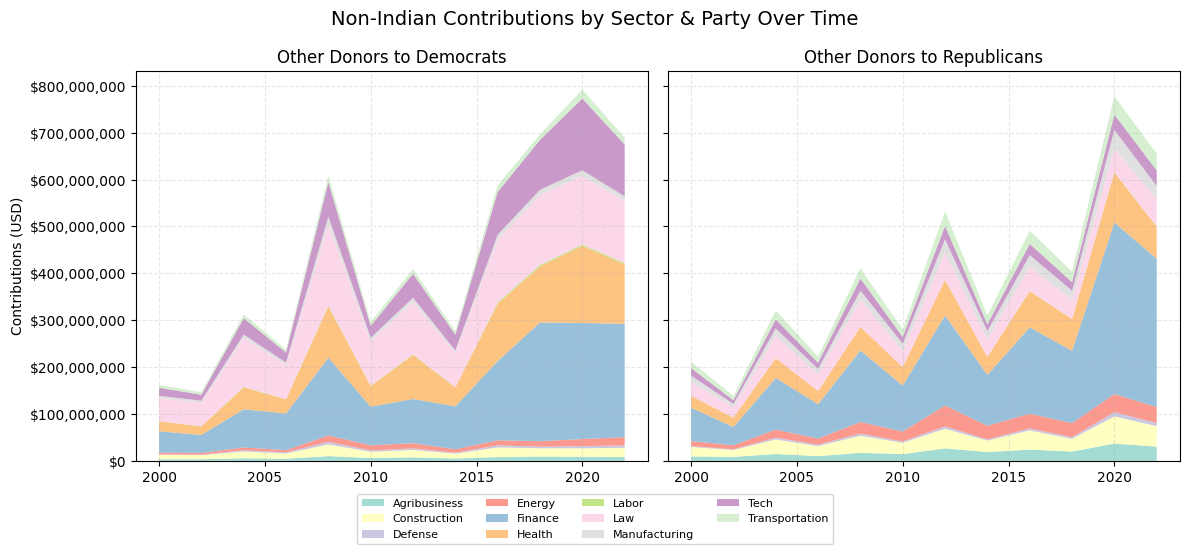

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sum_other_d = sectors_count_pivot.pivot(index='cycle', columns='sector', values='sum_other_d')
sum_other_r = sectors_count_pivot.pivot(index='cycle', columns='sector', values='sum_other_r')

ax1.stackplot(
    sum_other_d.index,
    sum_other_d.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Other Donors to Democrats", fontsize=12)
ax1.set_ylabel("Contributions (USD)")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    sum_other_r.index,
    sum_other_r.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Other Donors to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Non-Indian Contributions by Sector & Party Over Time", fontsize=14)
plt.tight_layout()
plt.show()

In [50]:
key_states = ['CA', 'TX', 'IL', 'NY', 'NJ', 'FL', 'VA', 'MA', 'WA']

states_count = donors.groupby(['cycle', 'state', 'indian', 'party']).agg(sum=('total_donated', 'sum'), count=('contrib_id', 'count')).reset_index()
states_count_pivot = states_count.pivot(index=['cycle', 'state'], columns=['indian', 'party'], values=['sum', 'count']).fillna(0).reset_index()
states_count_pivot.columns = ['cycle', 'state',
                      'sum_other_3', 'sum_other_d', 'sum_other_i', 'sum_other_l', 'sum_other_r',
                      'sum_indian_d', 'sum_indian_r', 'sum_other_u', 'sum_indian_3', 'sum_indian_l','sum_indian_i', 'sum_indian_u', 
                      'count_other_3', 'count_other_d', 'count_other_i', 'count_other_l', 'count_other_r', 
                      'count_indian_d', 'count_indian_r', 'count_other_u', 'count_indian_3', 'count_indian_l','count_indian_i', 'count_indian_u']

states_count_pivot['state'] = states_count_pivot['state'].where(states_count_pivot['state'].isin(key_states), 'Others')
states_count_pivot = states_count_pivot.groupby(['cycle', 'state']
).agg({
    'sum_other_d': 'sum',
    'sum_indian_d': 'sum',
    'sum_other_r': 'sum',
    'sum_indian_r': 'sum',
    'count_other_d': 'sum',
    'count_indian_d': 'sum',
    'count_other_r': 'sum',
    'count_indian_r': 'sum'
}).reset_index()

states_count_pivot

,cycle,state,sum_other_d,sum_indian_d,sum_other_r,sum_indian_r,count_other_d,count_indian_d,count_other_r,count_indian_r
0,2000,CA,33503164.0,537949.0,34367810.0,325636.0,40415.0,644.0,42626.0,437.0
1,2000,FL,13590428.0,168031.0,22222672.0,250704.0,16573.0,208.0,27279.0,297.0
2,2000,IL,12321485.0,171692.0,12449754.0,80000.0,15008.0,218.0,15828.0,104.0
3,2000,MA,11609622.0,69400.0,5021970.0,14650.0,15035.0,95.0,6364.0,16.0
4,2000,NJ,17752936.0,383178.0,19277003.0,165736.0,19948.0,501.0,22178.0,188.0
...,...,...,...,...,...,...,...,...,...,...
115,2022,NY,284046065.0,5753212.0,119927527.0,946223.0,148710.0,2424.0,69908.0,650.0
116,2022,Others,978699457.0,10812742.0,996547216.0,5222333.0,717742.0,7686.0,909124.0,4207.0
117,2022,TX,78308399.0,2082196.0,210283812.0,1307680.0,60357.0,1238.0,174498.0,901.0
118,2022,VA,58801288.0,1578054.0,205373713.0,298067.0,51735.0,959.0,60945.0,247.0


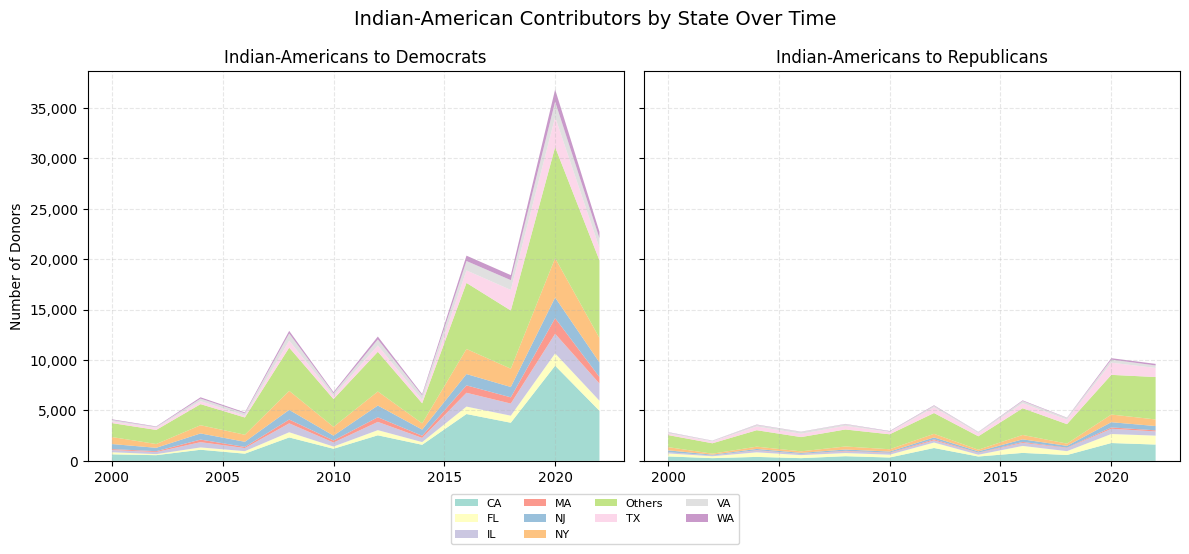

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

state_names = states_count_pivot["state"].unique()
colors = sns.color_palette("Set3", n_colors=len(state_names))

count_indian_d = states_count_pivot.pivot(index='cycle', columns='state', values='count_indian_d')
# sum_indian_d = sum_indian_d.div(sum_indian_d.sum(axis=1), axis=0) * 100
count_indian_r = states_count_pivot.pivot(index='cycle', columns='state', values='count_indian_r')
# sum_indian_r = sum_indian_r.div(sum_indian_r.sum(axis=1), axis=0) * 100

ax1.stackplot(
    count_indian_d.index,
    count_indian_d.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Indian-Americans to Democrats", fontsize=12)
ax1.set_ylabel("Number of Donors")
# ax1.set_ylim(0, 100)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    count_indian_r.index,
    count_indian_r.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Indian-American Contributors by State Over Time", fontsize=14)
plt.tight_layout()
plt.show()

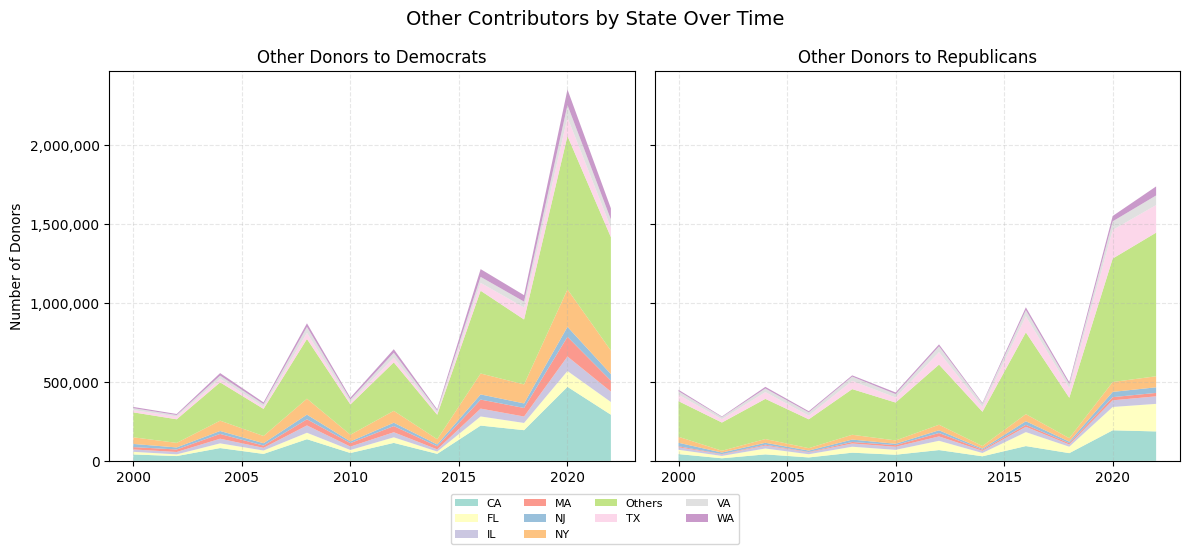

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

count_other_d = states_count_pivot.pivot(index='cycle', columns='state', values='count_other_d')
# sum_indian_d = sum_indian_d.div(sum_indian_d.sum(axis=1), axis=0) * 100
count_other_r = states_count_pivot.pivot(index='cycle', columns='state', values='count_other_r')
# sum_indian_r = sum_indian_r.div(sum_indian_r.sum(axis=1), axis=0) * 100

ax1.stackplot(
    count_other_d.index,
    count_other_d.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Other Donors to Democrats", fontsize=12)
ax1.set_ylabel("Number of Donors")
# ax1.set_ylim(0, 100)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    count_other_r.index,
    count_other_r.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Other Donors to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Other Contributors by State Over Time", fontsize=14)
plt.tight_layout()
plt.show()

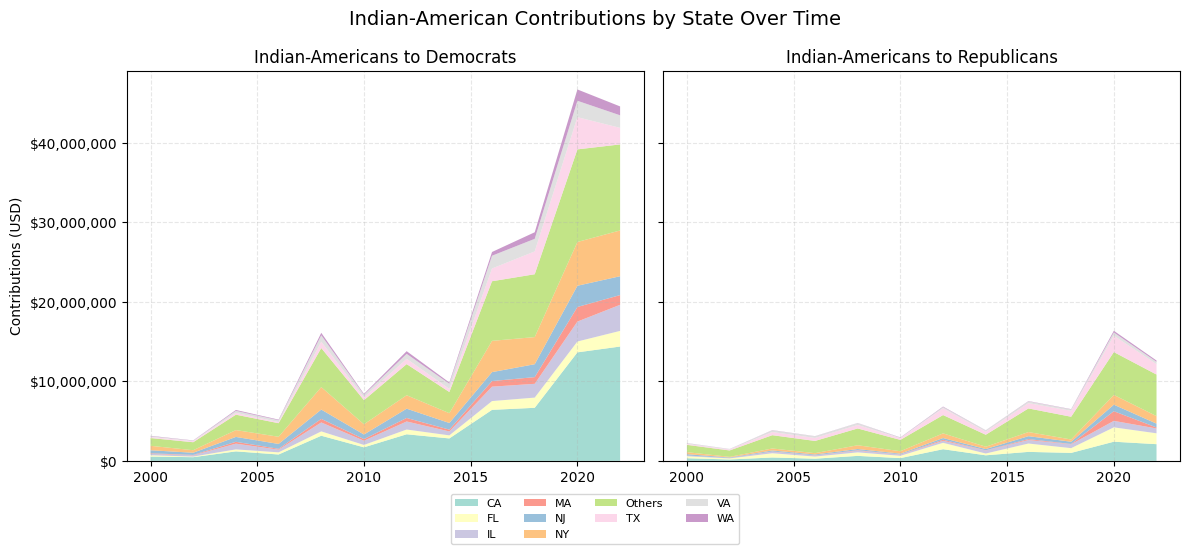

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sum_indian_d = states_count_pivot.pivot(index='cycle', columns='state', values='sum_indian_d')
# sum_indian_d = sum_indian_d.div(sum_indian_d.sum(axis=1), axis=0) * 100
sum_indian_r = states_count_pivot.pivot(index='cycle', columns='state', values='sum_indian_r')
# sum_indian_r = sum_indian_r.div(sum_indian_r.sum(axis=1), axis=0) * 100

ax1.stackplot(
    sum_indian_d.index,
    sum_indian_d.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Indian-Americans to Democrats", fontsize=12)
ax1.set_ylabel("Contributions (USD)")
# ax1.set_ylim(0, 100)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    sum_indian_r.index,
    sum_indian_r.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Indian-American Contributions by State Over Time", fontsize=14)
plt.tight_layout()
plt.show()

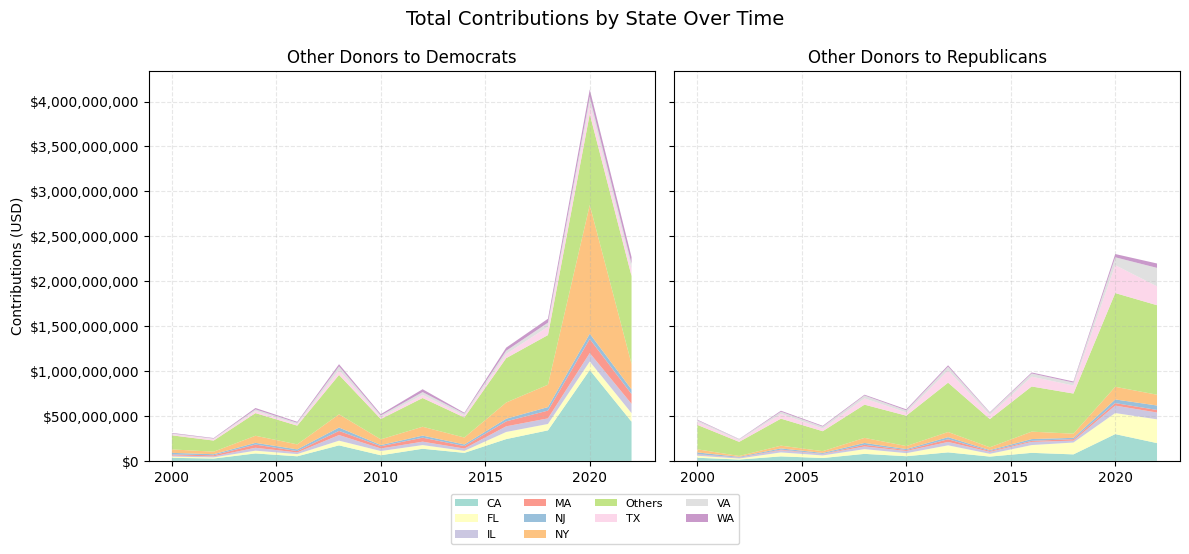

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sum_other_d = states_count_pivot.pivot(index='cycle', columns='state', values='sum_other_d')
# sum_other_d = sum_other_d.div(sum_other_d.sum(axis=1), axis=0) * 100
sum_other_r = states_count_pivot.pivot(index='cycle', columns='state', values='sum_other_r')
# sum_other_r = sum_other_r.div(sum_other_r.sum(axis=1), axis=0) * 100

ax1.stackplot(
    sum_other_d.index,
    sum_other_d.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Other Donors to Democrats", fontsize=12)
ax1.set_ylabel("Contributions (USD)")
# ax1.set_ylim(0, 100)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    sum_other_r.index,
    sum_other_r.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Other Donors to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Total Contributions by State Over Time", fontsize=14)
plt.tight_layout()
plt.show()

In [55]:
donors[(donors["cycle"] == 2020) & (donors["indian"] == True)].groupby(["name_y"])["total_donated"].sum().sort_values(ascending=False)[40:60]

name_y
David Perdue (R)                           461971.0
Nancy Pelosi Victory Fund                  455100.0
Unite the Country                          438900.0
Sara Gideon (D)                            438455.0
LCV Victory Fund                           406000.0
National Republican Senatorial Cmte        396442.0
Democratic Party of Wisconsin              390122.0
Mark Warner (D)                            342620.0
Rishi Kumar (D)                            338588.0
Michigan Democratic State Central Cmte     329620.0
Cal Cunningham (D)                         324449.0
Democratic Party of Texas                  303648.0
The IMPACT Fund                            295000.0
Tech for Campaigns                         290887.0
Lindsey Graham (R)                         289841.0
The Lincoln Project                        282464.0
Amy McGrath (D)                            274447.0
Democratic Party of Arizona                269818.0
Theresa Greenfield (D)                     262504.0
Minne

In [56]:
indian_donations = donors[(donors["indian"] == True)].groupby(["cycle", "name_y"])["total_donated"].sum()
total_donations = donors.groupby(["cycle", "name_y"])["total_donated"].sum()
eligible_candidates = total_donations[total_donations >= 10000]
percentage_indian_donations = (indian_donations / total_donations * 100).fillna(0)
percentage_indian_donations = percentage_indian_donations[percentage_indian_donations.index.isin(eligible_candidates.index)]

In [57]:
output = percentage_indian_donations.sort_values(ascending=False).reset_index()

indian_donations = indian_donations.reset_index()
total_donations = total_donations.reset_index()

output = percentage_indian_donations.reset_index()
output.columns = ["cycle", "name_y", "percentage_indian_donations"]

output = output.merge(total_donations, on=["cycle", "name_y"], how="left")
output = output.merge(indian_donations, on=["cycle", "name_y"], how="left")
output.rename(columns={"total_donated_x": "total_raised", "total_donated_y": "raised_from_indian"}, inplace=True)


In [58]:
output.sort_values(by="percentage_indian_donations", ascending=False)[:20]

,cycle,name_y,percentage_indian_donations,total_raised,raised_from_indian
52299,2022,Good Party,100.0,825000.0,825000.0
26362,2012,US India PAC,100.0,24980.0,24980.0
30632,2014,Satish W Korpe (D),100.0,10478.0,10478.0
42719,2018,Time to Unite Lead & Serve with Integrity,100.0,10500.0,10500.0
55929,2022,Susan Collins Victory Cmte,100.0,10500.0,10500.0
28732,2014,Indian Americans for Freedom,100.0,274150.0,274150.0
26942,2014,American Innovation PAC,100.0,10000.0,10000.0
30559,2014,Ron Sanyal (D),100.0,13830.0,13830.0
46517,2020,Keystone Communities Initiative,100.0,10000.0,10000.0
22435,2012,Bill Maske (D),100.0,12200.0,12200.0


In [59]:
output[output["name_y"].isin(["Shiva Ayyadurai (R)", "Sri Kulkarni (D)", "Shri Thanedar (D)", "Pramila Jayapal (D)", "Raja Krishnamoorthi (D)", "Ami Bera (D)", "Ro Khanna (D)"])].sort_values(by="percentage_indian_donations", ascending=False)

,cycle,name_y,percentage_indian_donations,total_raised,raised_from_indian
12492,2006,Ro Khanna (D),100.000000,13181.0,13181.0
48501,2020,Shiva Ayyadurai (R),89.477724,1170013.0,1046901.0
8811,2004,Ro Khanna (D),79.513413,321957.0,255999.0
55693,2022,Shri Thanedar (D),56.096682,86055.0,48274.0
25711,2012,Ro Khanna (D),53.778693,1233535.0,663379.0
35596,2016,Raja Krishnamoorthi (D),50.838299,2924315.0,1486672.0
41668,2018,Raja Krishnamoorthi (D),49.162776,4282545.0,2105418.0
47954,2020,Raja Krishnamoorthi (D),44.673268,5452968.0,2436019.0
17644,2010,Ami Bera (D),44.265767,2104039.0,931369.0
55047,2022,Raja Krishnamoorthi (D),42.501613,9896662.0,4206241.0


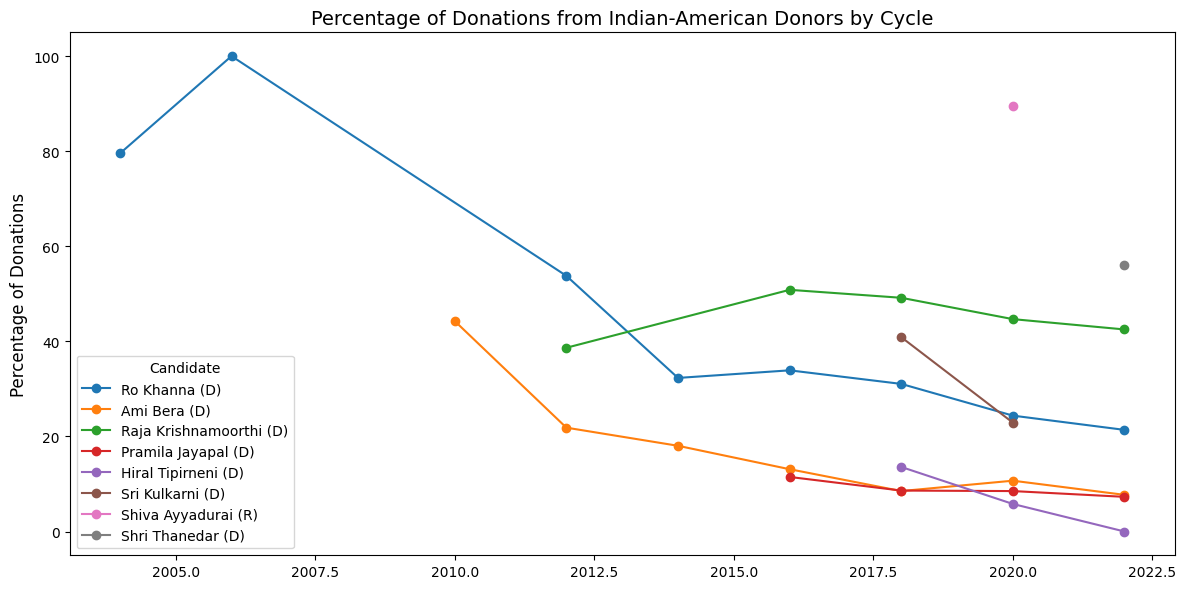

In [60]:
plt.figure(figsize=(12, 6))

# Plot one line per unique name_y
for name in output[output["name_y"].isin(["Hiral Tipirneni (D)", "Shiva Ayyadurai (R)", "Sri Kulkarni (D)", "Shri Thanedar (D)", "Pramila Jayapal (D)", "Raja Krishnamoorthi (D)", "Ami Bera (D)", "Ro Khanna (D)"])]["name_y"].unique():
    candidate_data = output[output["name_y"] == name]
    plt.plot(
        candidate_data["cycle"],
        candidate_data["percentage_indian_donations"],
        marker="o",
        label=name
    )

# Add labels, title, and legend
plt.title("Percentage of Donations from Indian-American Donors by Cycle", fontsize=14)
plt.ylabel("Percentage of Donations", fontsize=12)
plt.legend(title="Candidate", loc="lower left", fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

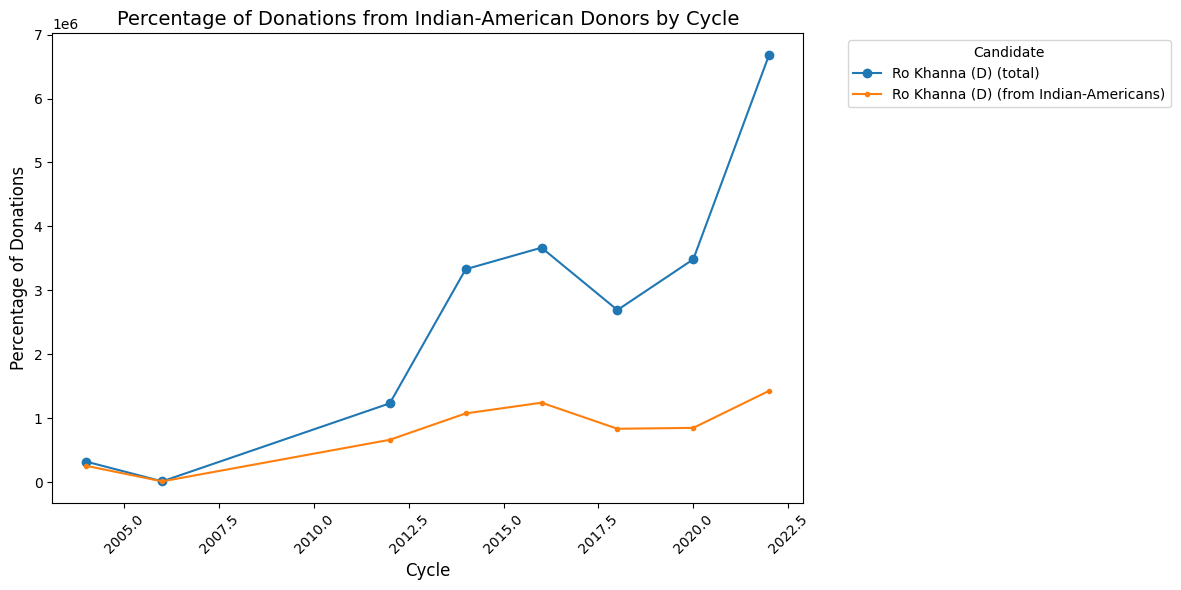

In [61]:
plt.figure(figsize=(12, 6))

# Plot one line per unique name_y
for name in output[output["name_y"].isin(["Ro Khanna (D)"])]["name_y"].unique():
    candidate_data = output[output["name_y"] == name]
    plt.plot(
        candidate_data["cycle"],
        candidate_data["total_raised"],
        marker="o",
        label=name + " (total)"
    )
    plt.plot(
        candidate_data["cycle"],
        candidate_data["raised_from_indian"],
        marker=".",
        label=name + " (from Indian-Americans)"
    )

# Add labels, title, and legend
plt.title("Percentage of Donations from Indian-American Donors by Cycle", fontsize=14)
plt.xlabel("Cycle", fontsize=12)
plt.ylabel("Percentage of Donations", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Candidate", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

In [62]:
donors[(donors["cycle"] == 2020) & (donors["name_y"] == "Raja Krishnamoorthi (D)")][:20]

,contrib_id,recip_id,name_new,realcode,gender,occupation,city,state,total_donated,donation_count,...,ran_general,type,cmte_id,pac_short,recip_id_pac,cand_id,recip_is_pac,dem_ratio,level,dollar_lean
19459302,i3003687417,N00033240,ramakrishna kanuri,Z9500,N,PHYSICIAN,BROOKSVILLE,FL,22400.0,5,...,Y,Other Donors,NaN,NaN,NaN,NaN,False,1.000000,House,22400.0
19459352,k00020187951,N00033240,manu shah,Z9500,M,MANAGEMENT,ORANGE,CA,22400.0,8,...,Y,"Top 10,000 Donors",NaN,NaN,NaN,NaN,False,1.000000,House,22400.0
19460885,q0001232527,N00033240,rama dandamudi,Z9500,N,PRESIDENT,CHICAGO,IL,21200.0,5,...,Y,Other Donors,NaN,NaN,NaN,NaN,False,1.000000,House,21200.0
19469149,h3001627213@,N00033240,ashley prasad,Y4000,F,HOMEMAKER,GLENCOE,IL,16800.0,4,...,Y,Other Donors,NaN,NaN,NaN,NaN,False,1.000000,House,16800.0
19469612,r0000065881,N00033240,asheesh goel,Z9500,U,ATTORNEY,WILLOWBROOK,IL,16800.0,4,...,Y,Other Donors,NaN,NaN,NaN,NaN,False,1.000000,House,16800.0
19470480,j1001692029,N00033240,murad alam,Z9500,M,PHYSICIAN,CHICAGO,IL,16200.0,5,...,Y,Other Donors,NaN,NaN,NaN,NaN,False,0.611111,House,16200.0
19472764,i30037790731,N00033240,rishi bhutada,Z9500,M,"VICE PRESIDENT, FINANCE",SUGAR LAND,TX,15000.0,8,...,Y,Other Donors,NaN,NaN,NaN,NaN,False,1.000000,House,15000.0
19478794,a00010370551,N00033240,babu kantemneni,Z9500,M,PHYSICIAN,DECATUR,AL,13700.0,4,...,Y,Other Donors,NaN,NaN,NaN,NaN,False,1.000000,House,13700.0
19484808,d0000772392A,N00033240,gloria wexler,Z9500,F,NOT EMPLOYED,GLENCOE,IL,12000.0,9,...,Y,Other Donors,NaN,NaN,NaN,NaN,False,1.000000,House,12000.0
19487774,k0001103772@,N00033240,alpana loyalka,H2100,F,NOT EMPLOYED,HOUSTON,TX,11200.0,3,...,Y,Other Donors,NaN,NaN,NaN,NaN,False,1.000000,House,11200.0


In [75]:
mean_all_by_year = donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["dem_ratio"].mean()
mean_ind_by_year = donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])[donors["indian"] == True].groupby(["cycle"])["dem_ratio"].mean()

In [69]:
dollar_mean_all_by_year = (
    donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)
dollar_mean_ind_by_year = (
    donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    [donors["indian"] == True]
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)

In [97]:
dollar_mean_pres_by_year = (
    donors[donors['level'] == 'President']
    .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)

dollar_mean_congress_by_year = (
    donors[donors['level'].isin(['House', 'Senate'])]
    .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)

dollar_mean_pres_ind_by_year = (
    donors[(donors["indian"] == True) & (donors['level'] == 'President')]
    .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)

dollar_mean_congress_ind_by_year = (
    donors[(donors["indian"] == True) & (donors['level'].isin(['House', 'Senate']))]
    .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)
dollar_mean_pac_by_year = (
    donors[(donors['recip_is_pac'] == True)]
    .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)
dollar_mean_pac_ind_by_year = (
    donors[(donors["indian"] == True) & (donors['recip_is_pac'] == True)]
    .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)

In [89]:
count_all_by_year = donors.groupby(["cycle"]).contrib_id.nunique()
count_ind_by_year = donors[donors["indian"] == True].groupby(["cycle"]).contrib_id.nunique()
count_pres_by_year = donors[donors['level'] == 'President'].groupby(["cycle"]).contrib_id.nunique()
count_congress_by_year = donors[donors['level'].isin(['House', 'Senate'])].groupby(["cycle"]).contrib_id.nunique()
count_pres_ind_by_year = donors[(donors["indian"] == True) & (donors['level'] == 'President')].groupby(["cycle"]).contrib_id.nunique()
count_congress_ind_by_year = donors[(donors["indian"] == True) & (donors['level'].isin(['House', 'Senate']))].groupby(["cycle"]).contrib_id.nunique()
count_pac_by_year = donors[(donors['recip_is_pac'] == True)].groupby(["cycle"]).contrib_id.nunique()
count_pac_ind_by_year = donors[(donors["indian"] == True) & (donors['recip_is_pac'] == True)].groupby(["cycle"]).contrib_id.nunique()

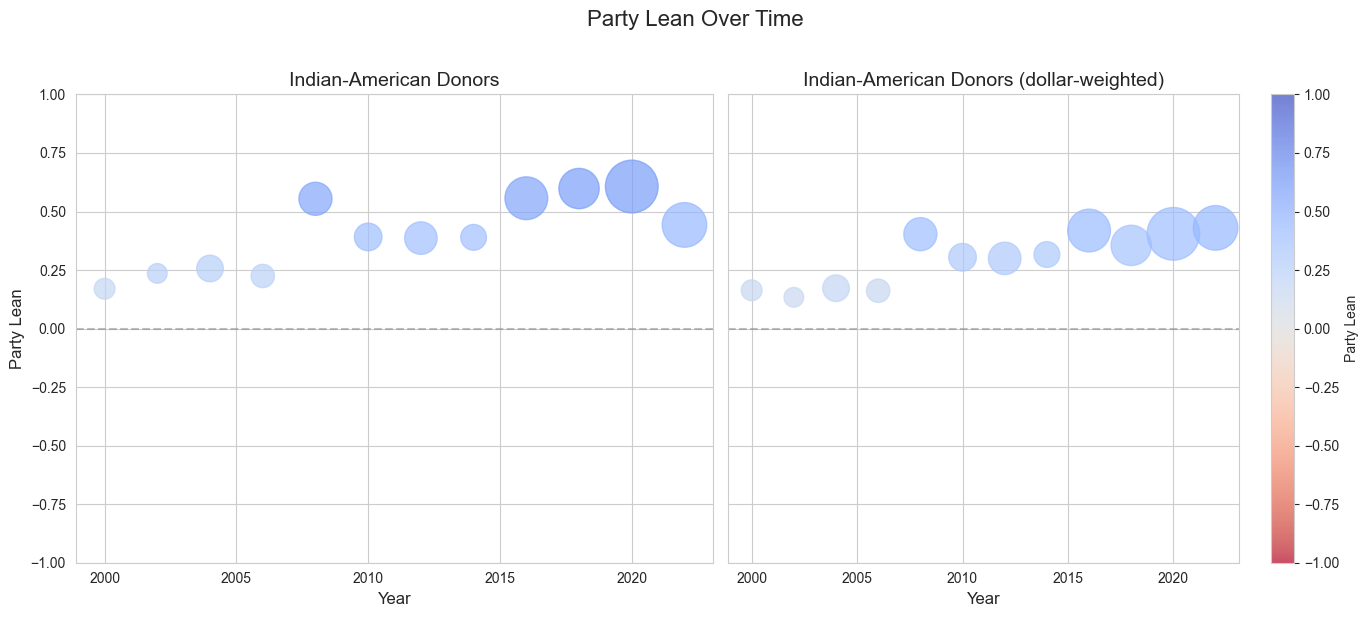

In [112]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(-1, 1)
norm2 = plt.Normalize(-1, 1)

sc1 = ax1.scatter(
    mean_ind_by_year.index,
    mean_ind_by_year,
    s=count_ind_by_year / 30,
    c=mean_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('Indian-American Donors', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(-1, 1)
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind_by_year.index,
    dollar_mean_ind_by_year,
    s=count_ind_by_year / 30,
    c=dollar_mean_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('Indian-American Donors (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(-1, 1)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

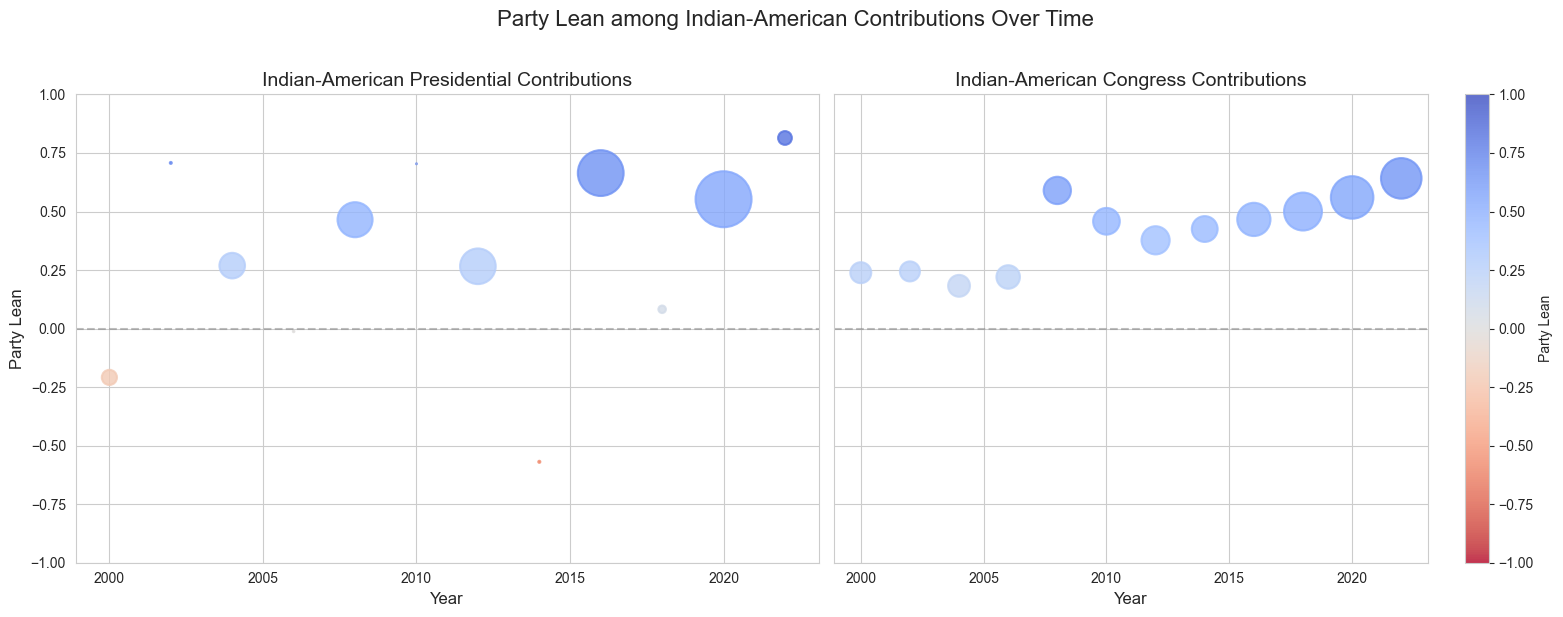

In [113]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.set_style("whitegrid")

norm1 = plt.Normalize(-1, 1)

sc1 = ax1.scatter(
    dollar_mean_pres_ind_by_year.index,
    dollar_mean_pres_ind_by_year,
    s=count_pres_ind_by_year / 10,
    c=dollar_mean_pres_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    alpha=0.8,
    norm=norm1,
    label='President',
    linewidths=1.5
)

ax1.set_title('Indian-American Presidential Contributions', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(-1, 1)
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
# ax1.legend(sc1.legend_elements()[0], ['President'], loc='upper left', fontsize=10)

sc2 = ax2.scatter(
    dollar_mean_congress_ind_by_year.index,
    dollar_mean_congress_ind_by_year,
    s=count_congress_ind_by_year / 20,
    c=dollar_mean_congress_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    alpha=0.8,
    norm=norm1,
    label='House/Senate',
    linewidths=1.5
)

ax2.set_title('Indian-American Congress Contributions', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(-1, 1)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
# ax2.legend(sc2.legend_elements()[0], ['House/Senate'], loc='upper left', fontsize=10)

cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean among Indian-American Contributions Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

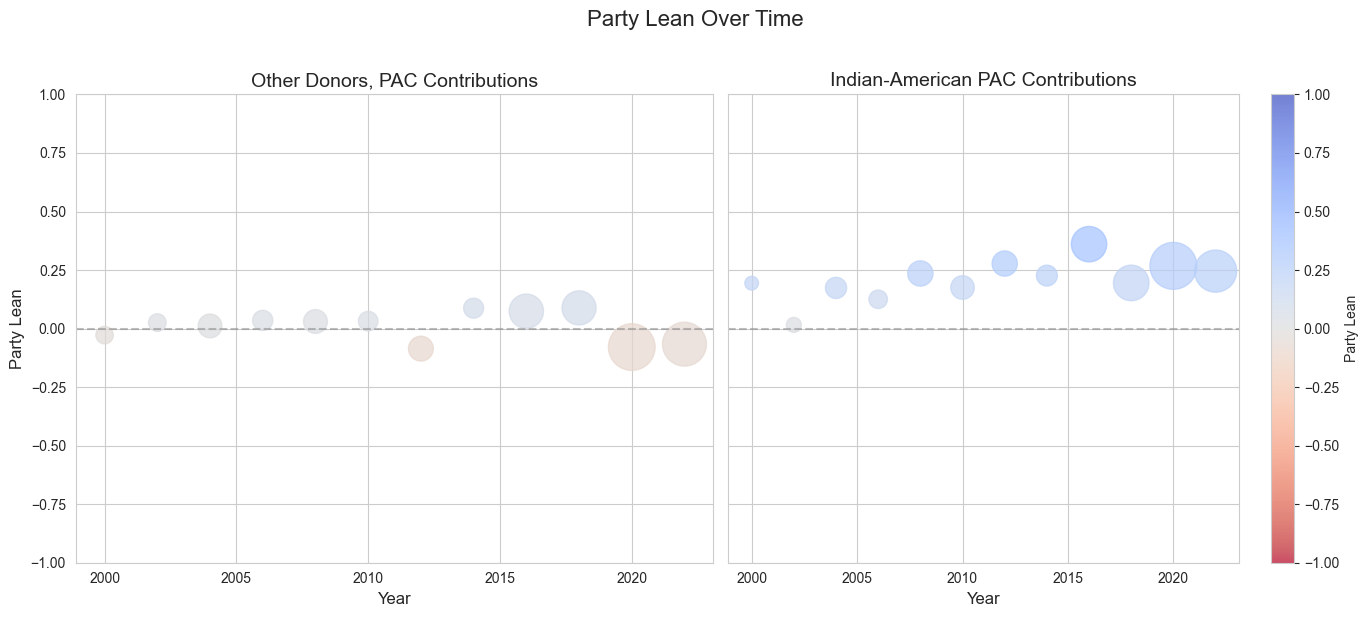

In [114]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(-1, 1)
norm2 = plt.Normalize(-1, 1)

sc1 = ax1.scatter(
    dollar_mean_pac_by_year.index,
    dollar_mean_pac_by_year,
    s=count_pac_by_year / 2000,
    c=dollar_mean_pac_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('Other Donors, PAC Contributions', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(-1, 1)
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_pac_ind_by_year.index,
    dollar_mean_pac_ind_by_year,
    s=count_pac_ind_by_year / 20,
    c=dollar_mean_pac_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('Indian-American PAC Contributions', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(-1, 1)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [99]:
dollar_mean_all = (
    donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle", "sector"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
    .unstack(level='sector')
)
dollar_mean_ind = (
    donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    [donors["indian"] == True]
    .groupby(["cycle", "sector"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
    .unstack(level='sector')
)

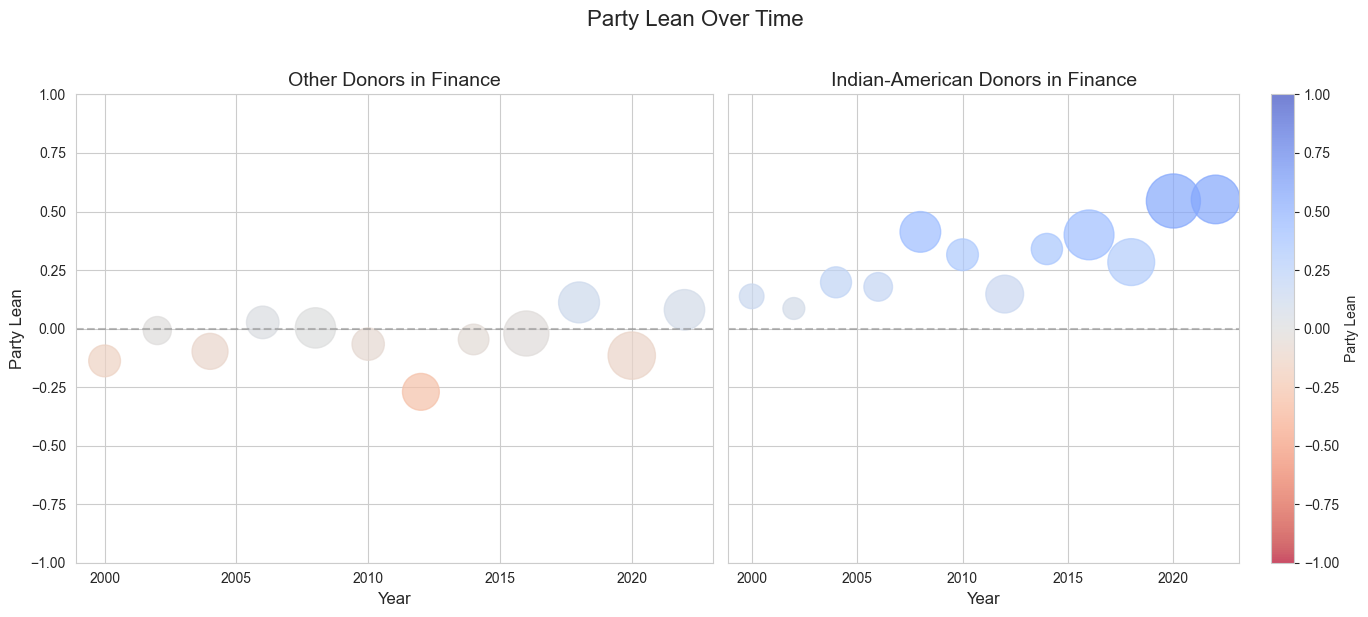

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(-1, 1)
norm2 = plt.Normalize(-1, 1)

sc1 = ax1.scatter(
    dollar_mean_all.index,
    dollar_mean_all["Finance"],
    s=donors[(donors["sector"] == "Finance")].groupby(["cycle"])["contrib_id"].nunique() / 200,
    c=dollar_mean_all["Finance"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('Other Donors in Finance', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(-1, 1)
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind.index,
    dollar_mean_ind["Finance"],
    s=donors[(donors["indian"] == True) & (donors["sector"] == "Finance")].groupby(["cycle"])["contrib_id"].nunique() / 2,
    c=dollar_mean_ind["Finance"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('Indian-American Donors in Finance', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(-1, 1)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

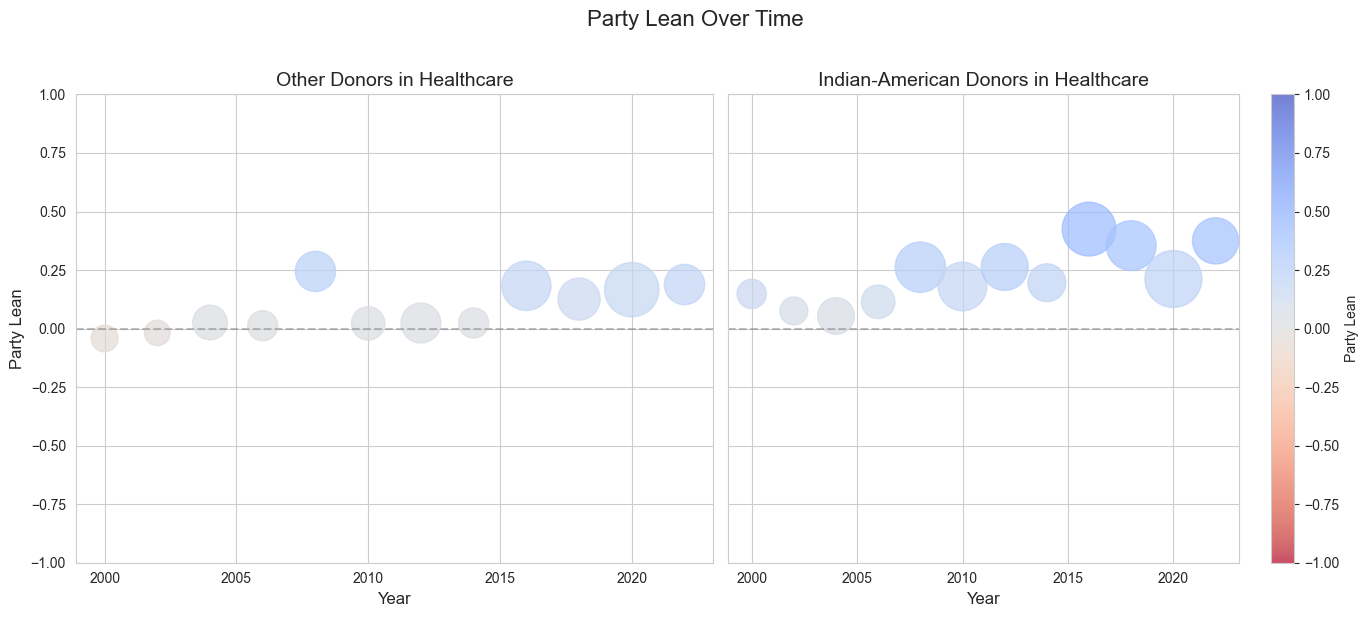

In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(-1, 1)
norm2 = plt.Normalize(-1, 1)

sc1 = ax1.scatter(
    dollar_mean_all.index,
    dollar_mean_all["Health"],
    s=donors[(donors["sector"] == "Health")].groupby(["cycle"])["contrib_id"].nunique() / 200,
    c=dollar_mean_all["Health"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('Other Donors in Healthcare', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(-1, 1)
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind.index,
    dollar_mean_ind["Health"],
    s=donors[(donors["indian"] == True) & (donors["sector"] == "Health")].groupby(["cycle"])["contrib_id"].nunique() / 4,
    c=dollar_mean_ind["Health"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('Indian-American Donors in Healthcare', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(-1, 1)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

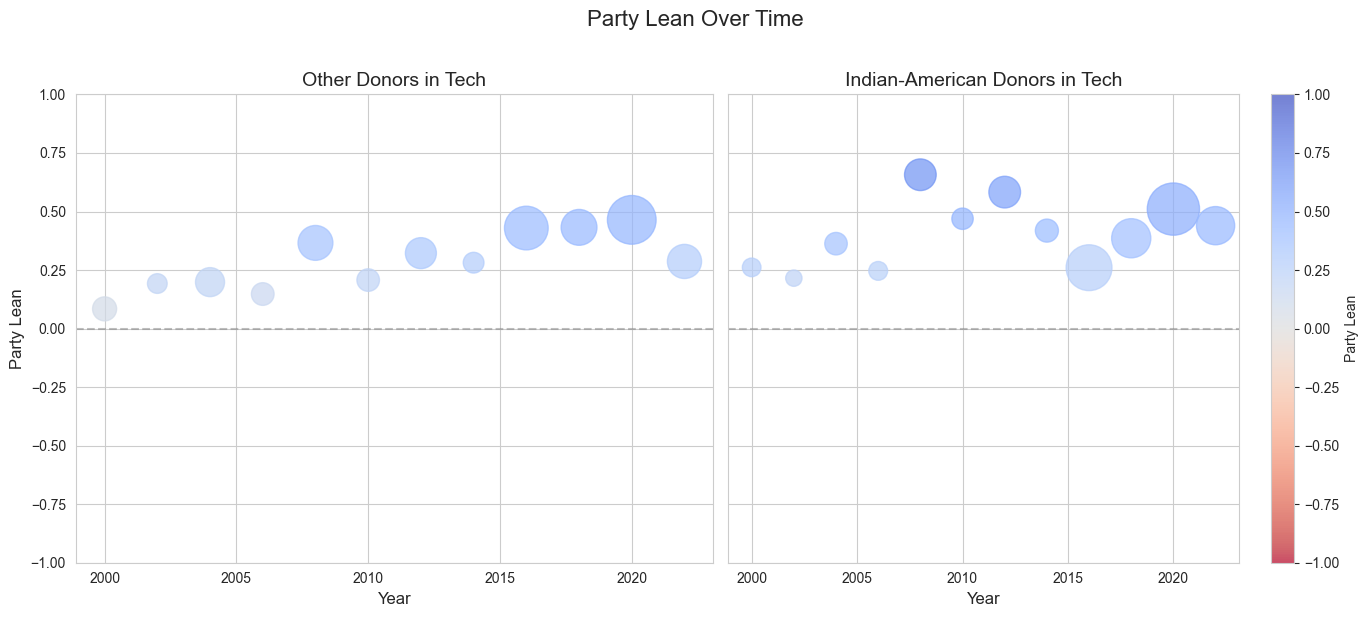

In [115]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(-1, 1)
norm2 = plt.Normalize(-1, 1)

sc1 = ax1.scatter(
    dollar_mean_all.index,
    dollar_mean_all["Tech"],
    s=donors[(donors["sector"] == "Tech")].groupby(["cycle"])["contrib_id"].nunique() / 100,
    c=dollar_mean_all["Tech"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('Other Donors in Tech', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(-1, 1)
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind.index,
    dollar_mean_ind["Tech"],
    s=donors[(donors["indian"] == True) & (donors["sector"] == "Tech")].groupby(["cycle"])["contrib_id"].nunique() / 2,
    c=dollar_mean_ind["Tech"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('Indian-American Donors in Tech', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(-1, 1)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [118]:
dollar_mean_pac_ind_by_year

cycle
2000    0.193917
2002    0.015671
2004    0.173726
2006    0.125046
2008    0.235319
2010    0.175326
2012    0.277740
2014    0.226264
2016    0.360502
2018    0.194957
2020    0.267835
2022    0.245380
dtype: float64

In [119]:
dollar_mean_ind["Finance"]

cycle
2000    0.137669
2002    0.085809
2004    0.197560
2006    0.178071
2008    0.412953
2010    0.315381
2012    0.147328
2014    0.339824
2016    0.400188
2018    0.283899
2020    0.544938
2022    0.551557
Name: Finance, dtype: float64

In [120]:
donors[donors["cycle"] == 2020].groupby("sector")["total_donated"].sum().sort_values(ascending=False)

MemoryError: Unable to allocate 708. MiB for an array with shape (13, 7136236) and data type object

In [ ]:
donors[donors["cycle"] == 2000].groupby("sector")["total_donated"].sum().sort_values(ascending=False)

In [122]:
donors[donors["name_new"] == "bharat bhise"].groupby(["cycle", "name_new"])["total_donated"].sum()

cycle  name_new    
2010   bharat bhise      2000.0
2020   bharat bhise    660735.0
2022   bharat bhise    276400.0
Name: total_donated, dtype: float64